In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,auc,confusion_matrix,make_scorer
from hyperopt import fmin, tpe, hp, Trials
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# VERİ DOĞRULAMA

- MUSTERI_ID : Müşterileri ayırt eden unique ID'ler.
- LABEL: Müşterinin aldığı Hayat sigortası ürününün çeşidi.
- FLAG: Verinin ait olduğu ay.
- PP_CINSIYET: Sözleşme sahibinin cinsiyeti.
- 1: Erkek
- 2: Kadın
- PP_YAS : Sözleşme sahibinin ay bazlı olarak yaşı.
- PP_MESLEK : Sözleşme sahibinin mesleği.
- PP_MUSTERI_SEGMENTI : Sözleşme sahibinin müşteri segmenti.
- 101: A segment
- 102: B segment
- 103: C segment
- 104: D segment
- 105: E segment
- 106: F segment
- PP_UYRUK: Sözleşme sahibinin uyruk bilgisi.
- 1:TC Vatandaşı
- 2:Mavi Kart
- 3:Yabancı Uyruklu
- IL:Sözleşme sahiplerinin yaşadığı illere ait plaka kodu.( 0 = Yurtdışı)
- SORU_YATIRIM_KARAKTERI_CVP: Sözleşme sahibinin ankete verdiği cevaplara göre belirlenen yatırım karakteri.
- SORU_YATIRIM_KARAKTERI_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_MEDENI_HAL_CVP: Sözleşme sahibinin ankete verdiği cevaba göre medeni durumu.
- SORU_MEDENI_HAL_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_EGITIM_CVP: Sözleşme sahibinin ankete verdiği cevaplara göre eğitim durumu.
- SORU_EGITIM_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_GELIR_CVP: Sözleşme sahibinin ankete verdiği cevaba göre gelir durumu.
- SORU_GELIR_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_COCUK_SAYISI_CVP: Sözleşme sahibinin ankete verdiği cevaba göre çocuk sayısı.
- SORU_COCUK_SAYISI_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- BES_AYRILMA_TALEP_ADET : Sözleşme sahibinin BES hesabından ayrılmak için açtığı talep sayısı.
- ODEM EME_TALEP_ADET : Sözleşme sahibinin son 1 sene içerisinde kaç kez ödememe talimatı verdiğini gösterir.
- HAYAT_AYRILMA_TALEP_ADET : Sözleşme sahibinin Hayat sigortasından ayrılmak için açtığı talep sayısı.
- BILGI_TALEP_ADET : Sözleşme sahibinin sözleşmesi için kaç kez bilgi talep ettiğini gösterir.
- VADE_TUTAR_0 - VADE_TUTAR_11 : Sözleşme sahibinin sahip olduğu ürünlerin son 12 aya ait toplam vade tutarları
- ODEME_TUTAR_0 - ODEME_TUTAR_11 : Sözleşme sahibinin sahip olduğu ürünler için son 12 ayda yaptığı ödeme tutarları
- SON_AY_KATKI_MIKTARI : Sözleşme sahibinin son bir ay içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_AY_KATKI_ADET : Sözleşme sahibinin son bir ay içinde yaptığı ek katkı ödemelerinin adedi
- SON_CEYREK_KATKI_MIKTARI : Sözleşme sahibinin son üç ay içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_CEYREK_KATKI_ADET : Sözleşme sahibinin son üç ay içinde yaptığı ek katkı ödemelerinin adedi
- SON_SENE_KATKI_MIKTARI : Sözleşme sahibinin son bir sene içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_SENE_KATKI_ADET : Sözleşme sahibinin son bir sene içinde yaptığı ek katkı ödemelerinin adedi
- ANAPARA: Sözleşme sahibinin TL cinsinden toplam yatırdığı para miktarı.
- GETIRI : Sözleşme sahibinin TL cinsinden yatirdiği paradan elde ettiği getiri.
- BU1 - BU24: BES ÜRÜN 1 - 24, Kişinin kolonda belirtilen BES ürününe sahip olup olmama durumu (Ürün özellikleri ayrı bir dokumanda verilmiştir)
- HU1 - HU19: HAYAT ÜRÜN 1 - 19, Kişinin kolonda belirtilen Hayat ürününe sahip olup olmama durumu (Ürün özellikleri ayrı bir dokumanda verilmiştir)
- AKTIF_ILK_POLICE_RG: Sözleşme sahibinin aktif olan poliçeleri arasından en eskisinin üstünden geçen süre (ay).


In [2]:
train = pd.read_csv("data/train.csv")
train["ID"] = range(0,len(train))
train.tail()

MUSTERI_ID  \
852714  4a245f1a49af39319faa41668d6ee425fb71c7a75e8b22fab2f39be5ecd76739   
852715  2087a8e5f1f98d143011df1cccaa0331e3427b1a1e642e265370aed1c8d566fa   
852716  8d4dccb1bd4763e909476935805d99b84e7f2098b646b7f1f7cd3f41ed5d60fb   
852717  e33a48c42db1da438d54da64cf59ef4acae4583bd4effcb727648c91269d7a16   
852718  59fd829fc435bf3ed0aa832ca0c89397e5197d8cc135187362d77495cc5d5bdd   

       LABEL     FLAG  PP_CINSIYET  PP_YAS  PP_MESLEK  PP_MUSTERI_SEGMENTI  \
852714    UA    MAYIS            1     551       İşçi                  105   
852715    UA  HAZIRAN            2     466  Ev Hanımı                  104   
852716    UA    MAYIS            1     139       İşçi                  106   
852717    UA    MAYIS            2     303        NaN                  106   
852718    UA    MAYIS            2     325  Ev Hanımı                  106   

        PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG  \
852714         1  35                        NaN                        NaN   
852715         1  33                        NaN                        NaN   
852716         1  28                        NaN                        NaN   
852717         1  20                        NaN                        NaN   
852718         1  47                        NaN                        NaN   

       SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  \
852714             Married                 9.0          Lisans   
852715             Married                53.0          Lisans   
852716              Single               234.0            Lise   
852717              Single                74.0         (Diğer)   
852718             Married                46.0            Lise   

        SORU_EGITIM_RG SORU_GELIR_CVP  SORU_GELIR_RG  SORU_COCUK_SAYISI_CVP  \
852714             9.0            NaN            NaN                    NaN   
852715            53.0        30000.0           53.0                    NaN   
852716           234.0         4000.0          234.0                    0.0   
852717            74.0         3000.0           74.0                    NaN   
852718            46.0         3000.0           46.0                    NaN   

        SORU_COCUK_SAYISI_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
852714                   NaN                       0                   0   
852715                   NaN                       0                   0   
852716                 234.0                       0                   0   
852717                   NaN                       0                   0   
852718                   NaN                       0                   0   

        HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  \
852714                         0                 0           430   
852715                         0                 0          1368   
852716                         0                 0           317   
852717                         0                 0           430   
852718                         0                 0           430   

        ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  \
852714            430           430            430           430   
852715           1368          1368           1368          1368   
852716              0           317              0           317   
852717              0           430              0           430   
852718              0           430              0           430   

        ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
852714            430             0              0          1914   
852715           1368          1368           1368          1368   
852716              0           317              0           174   
852717              0           430              0           229   
852718              0           430              0           229   

        ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  \
852714           1914          1914        

In [3]:
train.shape

(852719, 98)

In [4]:
# Train ile test concat için aynı yapıya getiriliyor. 
test = pd.read_csv("data/test.csv")
test_initial_id = 852719
test["LABEL"] = np.nan
test["ID"] = range(test_initial_id,test_initial_id + len(test))
test = test[train.columns]
test.head()

MUSTERI_ID  LABEL  \
0  15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8    NaN   
1  7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0    NaN   
2  47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e    NaN   
3  48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87    NaN   
4  26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7    NaN   

    FLAG  PP_CINSIYET  PP_YAS       PP_MESLEK  PP_MUSTERI_SEGMENTI  PP_UYRUK  \
0  KASIM            2     467        Öğretmen                  103         1   
1  KASIM            1     658        Öğretmen                  106         1   
2  KASIM            1     634  Serbest Meslek                  106         1   
3  KASIM            2     638             NaN                  106         1   
4  KASIM            1      80         Öğrenci                  106         1   

     IL SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG  \
0   1.0                        NaN                        NaN   
1  54.0                        NaN                        NaN   
2  48.0                        NaN                        NaN   
3  67.0                        NaN                        NaN   
4  34.0                        NaN                        NaN   

  SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  SORU_EGITIM_RG  \
0             Married               101.0             NaN             NaN   
1             Married               112.0          Lisans           112.0   
2             Married               219.0            Lise           219.0   
3             Married               208.0            Lise           208.0   
4              Single                 4.0         (Diğer)             4.0   

  SORU_GELIR_CVP  SORU_GELIR_RG  SORU_COCUK_SAYISI_CVP  SORU_COCUK_SAYISI_RG  \
0           3000          101.0                    0.0                 101.0   
1           2800          112.0                    2.0                 112.0   
2           2000          219.0                    0.0                 219.0   
3              0          208.0                    0.0                 208.0   
4            NaN            NaN                    NaN                   NaN   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  \
0                 0           602              0           602              0   
1                 0           976            976           976            976   
2                 0          2497              0          2497              0   
3                 0           679              0           679              0   
4                 0           334            334           334            334   

   VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
0           602              0           602              0           602   
1           976            976           976            976           976   
2          2497              0          2497              0          2497   
3           679              0           679              0           679   
4           334            334           334            334             0   

   ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  \
0              0           602              0           602              0   
1            976           976            976           976            976   
2              0          2497              0          2497              0   
3              0           679              0           679

In [5]:
test.shape

(195631, 98)

In [6]:
submission_df = pd.read_csv("data/sample_submission.csv")
submission_df.head()

MUSTERI_ID  LABEL
0  15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8    NaN
1  7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0    NaN
2  47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e    NaN
3  48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87    NaN
4  26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7    NaN

In [7]:
submission_df.shape

(195631, 2)

**Submission ve test datada MUSTERİ ID kontrolü**

In [8]:
customer_id_check= submission_df["MUSTERI_ID"] == test["MUSTERI_ID"]
diff_customer_id = len(test) - customer_id_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_customer_id)

Değerleri farklı olan satır sayısı: 0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852719 entries, 0 to 852718
Data columns (total 98 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   MUSTERI_ID                  852719 non-null  object 
 1   LABEL                       852719 non-null  object 
 2   FLAG                        852719 non-null  object 
 3   PP_CINSIYET                 852719 non-null  int64  
 4   PP_YAS                      852719 non-null  int64  
 5   PP_MESLEK                   764099 non-null  object 
 6   PP_MUSTERI_SEGMENTI         852719 non-null  int64  
 7   PP_UYRUK                    852719 non-null  int64  
 8   IL                          852719 non-null  int64  
 9   SORU_YATIRIM_KARAKTERI_CVP  132698 non-null  object 
 10  SORU_YATIRIM_KARAKTERI_RG   132698 non-null  float64
 11  SORU_MEDENI_HAL_CVP         850939 non-null  object 
 12  SORU_MEDENI_HAL_RG          850939 non-null  float64
 13  SORU_EGITIM_CV

In [10]:
train.describe().T

count           mean            std       min  \
PP_CINSIYET                852719.0       1.494226       0.499967       1.0   
PP_YAS                     852719.0     440.773115     205.058165       0.0   
PP_MUSTERI_SEGMENTI        852719.0     104.740901       1.425773     101.0   
PP_UYRUK                   852719.0       1.007269       0.107100       1.0   
IL                         852719.0      31.022318      18.434540       0.0   
SORU_YATIRIM_KARAKTERI_RG  132698.0      28.250674      11.966714       0.0   
SORU_MEDENI_HAL_RG         850939.0      87.329307      69.144079       0.0   
SORU_EGITIM_RG             725624.0      84.778107      71.030740       0.0   
SORU_GELIR_RG              574817.0     103.253851      63.343308       0.0   
SORU_COCUK_SAYISI_CVP      436159.0       0.112335       4.568026       0.0   
SORU_COCUK_SAYISI_RG       436159.0     141.920219      51.963410      72.0   
BES_AYRILMA_TALEP_ADET     852719.0       0.010281       0.114947       0.0   
ODEMEME_TALEP_ADET         852719.0       0.000408       0.023573       0.0   
HAYAT_AYRILMA_TALEP_ADET   852719.0       0.000569       0.027240       0.0   
BILGI_TALEP_ADET           852719.0       0.002089       0.087839       0.0   
VADE_TUTAR_0               852719.0    1167.957393    4294.029997       0.0   
ODEME_TUTAR_0              852719.0     687.891499    3201.321654       0.0   
VADE_TUTAR_1               852719.0     895.147545    1296.980403       0.0   
ODEME_TUTAR_1              852719.0     601.841583    1203.734769       0.0   
VADE_TUTAR_2               852719.0     870.184179    1250.228654       0.0   
ODEME_TUTAR_2              852719.0     595.238552    1175.512140       0.0   
VADE_TUTAR_3               852719.0     868.939027    1264.731995       0.0   
ODEME_TUTAR_3              852719.0     594.898561    1169.151019       0.0   
VADE_TUTAR_4               852719.0     756.090768    1135.880375       0.0   
ODEME_TUTAR_4              852719.0     526.193782    1073.709956       0.0   
VADE_TUTAR_5               852719.0     621.828441     975.824602       0.0   
ODEME_TUTAR_5              852719.0     437.912835     926.889169       0.0   
VADE_TUTAR_6               852719.0     587.456773    1012.085053       0.0   
ODEME_TUTAR_6              852719.0     411.157705     934.960770       0.0   
VADE_TUTAR_7               852719.0     520.239067     847.263775       0.0   
ODEME_TUTAR_7              852719.0     367.928009     811.048254       0.0   
VADE_TUTAR_8               852719.0     474.581990     770.281077       0.0   
ODEME_TUTAR_8              852719.0     335.411839     731.296987       0.0   
VADE_TUTAR_9               852719.0     437.400763     728.158681       0.0   
ODEME_TUTAR_9              852719.0     306.716417     685.654602       0.0   
VADE_TUTAR_10              852719.0     416.588563     668.824418       0.0   
ODEME_TUTAR_10             852719.0     291.900822     642.134642       0.0   
VADE_TUTAR_11              852719.0     406.869434     705.809218       0.0   
ODEME_TUTAR_11             852719.0     283.587381     656.317911       0.0   
SON_AY_KATKI_MIKTARI          980.0     675.524490    5284.490182       0.0   
SON_AY_KATKI_ADET             980.0       1.065306       0.421366       1.0   
SON_CEYREK_KATKI_MIKTARI     5620.0    4077.132562   11775.604867       0.0   
SON_CEYREK_KATKI_ADET        5620.0       1.718327       3.343935       1.0   
SON_SENE_KATKI_MIKTARI      15006.0    7045.616953   16583.438009       0.0   
SON_SENE_KATKI_ADET         15006.0       2.837598       6.062417       1.0   
ANAPARA                    852719.0   17413.149898   39168.960560       0.0   
GETIRI                     852719.0   32790.044159  109231.501245 -334227.0   
BU01                       852719.0       0.046230       0.211568       0.0   
BU02                       852719.0       0.093469       0.305716       0.0   
BU03                       852719.0       0.006851       0.085503       0.0   
B

MUSTERI_ID

In [11]:
train["MUSTERI_ID"].nunique()

852719

In [12]:
test["MUSTERI_ID"].nunique()

195631

TRAIN ILE TEST BIRLEŞTİRİLİP BERABER İŞLEM YAPILACAK

In [13]:
train_test_concat = pd.concat([train,test],axis=0)

In [14]:
train_test_concat.head(1)

MUSTERI_ID LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    UA   

      FLAG  PP_CINSIYET  PP_YAS PP_MESLEK  PP_MUSTERI_SEGMENTI  PP_UYRUK  \
0  HAZIRAN            2     505  Öğretmen                  105         1   

     IL SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG  \
0  34.0                        NaN                        NaN   

  SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  SORU_EGITIM_RG  \
0              Single                68.0         (Diğer)            68.0   

  SORU_GELIR_CVP  SORU_GELIR_RG  SORU_COCUK_SAYISI_CVP  SORU_COCUK_SAYISI_RG  \
0            NaN            NaN                    NaN                   NaN   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   

   BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  \
0                 0           405            405           405            405   

   VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
0           405            405           405            405           405   

   ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  \
0            405           220            220           220            220   

   VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  \
0           220            220           220            220           220   

   ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  VADE_TUTAR_11  \
0            220              0               0              0   

   ODEME_TUTAR_11  SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  \
0               0                   NaN                NaN   

   SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  \
0                       NaN                    NaN                     NaN   

   SON_SENE_KATKI_ADET  ANAPARA  GETIRI  BU01  BU02  BU03  BU04  BU05  BU06  \
0                  NaN     2654     132     1     0     0     0     0     0   

   BU07  BU08  BU09  BU10  BU11  BU12  BU13  BU14  BU15  BU16  BU17  BU18  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   BU19  BU20  BU21  BU22  BU23  BU24  HU01  HU02  HU03  HU04  HU05  HU06  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   HU07  HU10  HU11  HU12  HU13  HU14  HU15  HU16  HU17  HU18  HU19  \
0     0     0     0     0     0     0     0     0     0     0     0   

   AKTIF_ILK_POLICE_RG  ID  
0                    9   0

In [15]:
train_test_concat.tail(1)

MUSTERI_ID  \
195630  08c299b06dbf1f9a5e3695f7234c752a53b87654bf336b40f8f2b97ff11ac98d   

       LABEL    FLAG  PP_CINSIYET  PP_YAS PP_MESLEK  PP_MUSTERI_SEGMENTI  \
195630   NaN  ARALIK            2       3       NaN                  106   

        PP_UYRUK    IL SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG  \
195630         1  35.0                     Yetkin                        3.0   

       SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  \
195630              Single                 3.0             NaN   

        SORU_EGITIM_RG SORU_GELIR_CVP  SORU_GELIR_RG  SORU_COCUK_SAYISI_CVP  \
195630             NaN            NaN            NaN                    NaN   

        SORU_COCUK_SAYISI_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
195630                   NaN                       0                   0   

        HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  \
195630                         0                 0           382   

        ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  \
195630            382           382            382           382   

        ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
195630            382             0              0             0   

        ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  \
195630              0             0              0             0   

        ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  \
195630              0             0              0             0   

        ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  VADE_TUTAR_10  \
195630              0             0              0              0   

        ODEME_TUTAR_10  VADE_TUTAR_11  ODEME_TUTAR_11  SON_AY_KATKI_MIKTARI  \
195630               0              0               0                   NaN   

        SON_AY_KATKI_ADET  SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  \
195630                NaN                     365.0                    1.0   

        SON_SENE_KATKI_MIKTARI  SON_SENE_KATKI_ADET  ANAPARA  GETIRI  BU01  \
195630                   365.0                  1.0     1427      22     0   

        BU02  BU03  BU04  BU05  BU06  BU07  BU08  BU09  BU10  BU11  BU12  \
195630     0     0     0     0     0     0     0     0     0     0     0   

        BU13  BU14  BU15  BU16  BU17  BU18  BU19  BU20  BU21  BU22  BU23  \
195630     0     0     0     0     0     0     0     0     0     0     1   

        BU24  HU01  HU02  HU03  HU04  HU05  HU06  HU07  HU10  HU11  HU12  \
195630     0     0     0     0     0     0     0     0     0     0     0   

        HU13  HU14  HU15  HU16  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG       ID  
195630     0     0     0     0     0     0     0                    2  1048349

In [16]:
train_test_concat.shape

(1048350, 98)

**EKSİK VERİ İŞLEMLERİ**

In [17]:
train_test_concat.isnull().sum()

MUSTERI_ID                          0
LABEL                          195631
FLAG                                0
PP_CINSIYET                         0
PP_YAS                              0
PP_MESLEK                      115059
PP_MUSTERI_SEGMENTI                 0
PP_UYRUK                            0
IL                                  1
SORU_YATIRIM_KARAKTERI_CVP     888265
SORU_YATIRIM_KARAKTERI_RG      888265
SORU_MEDENI_HAL_CVP              2096
SORU_MEDENI_HAL_RG               2096
SORU_EGITIM_CVP                154179
SORU_EGITIM_RG                 154179
SORU_GELIR_CVP                 357601
SORU_GELIR_RG                  357601
SORU_COCUK_SAYISI_CVP          530095
SORU_COCUK_SAYISI_RG           530095
BES_AYRILMA_TALEP_ADET              0
ODEMEME_TALEP_ADET                  0
HAYAT_AYRILMA_TALEP_ADET            0
BILGI_TALEP_ADET                    0
VADE_TUTAR_0                        0
ODEME_TUTAR_0                       0
VADE_TUTAR_1                        0
ODEME_TUTAR_

<Axes: >

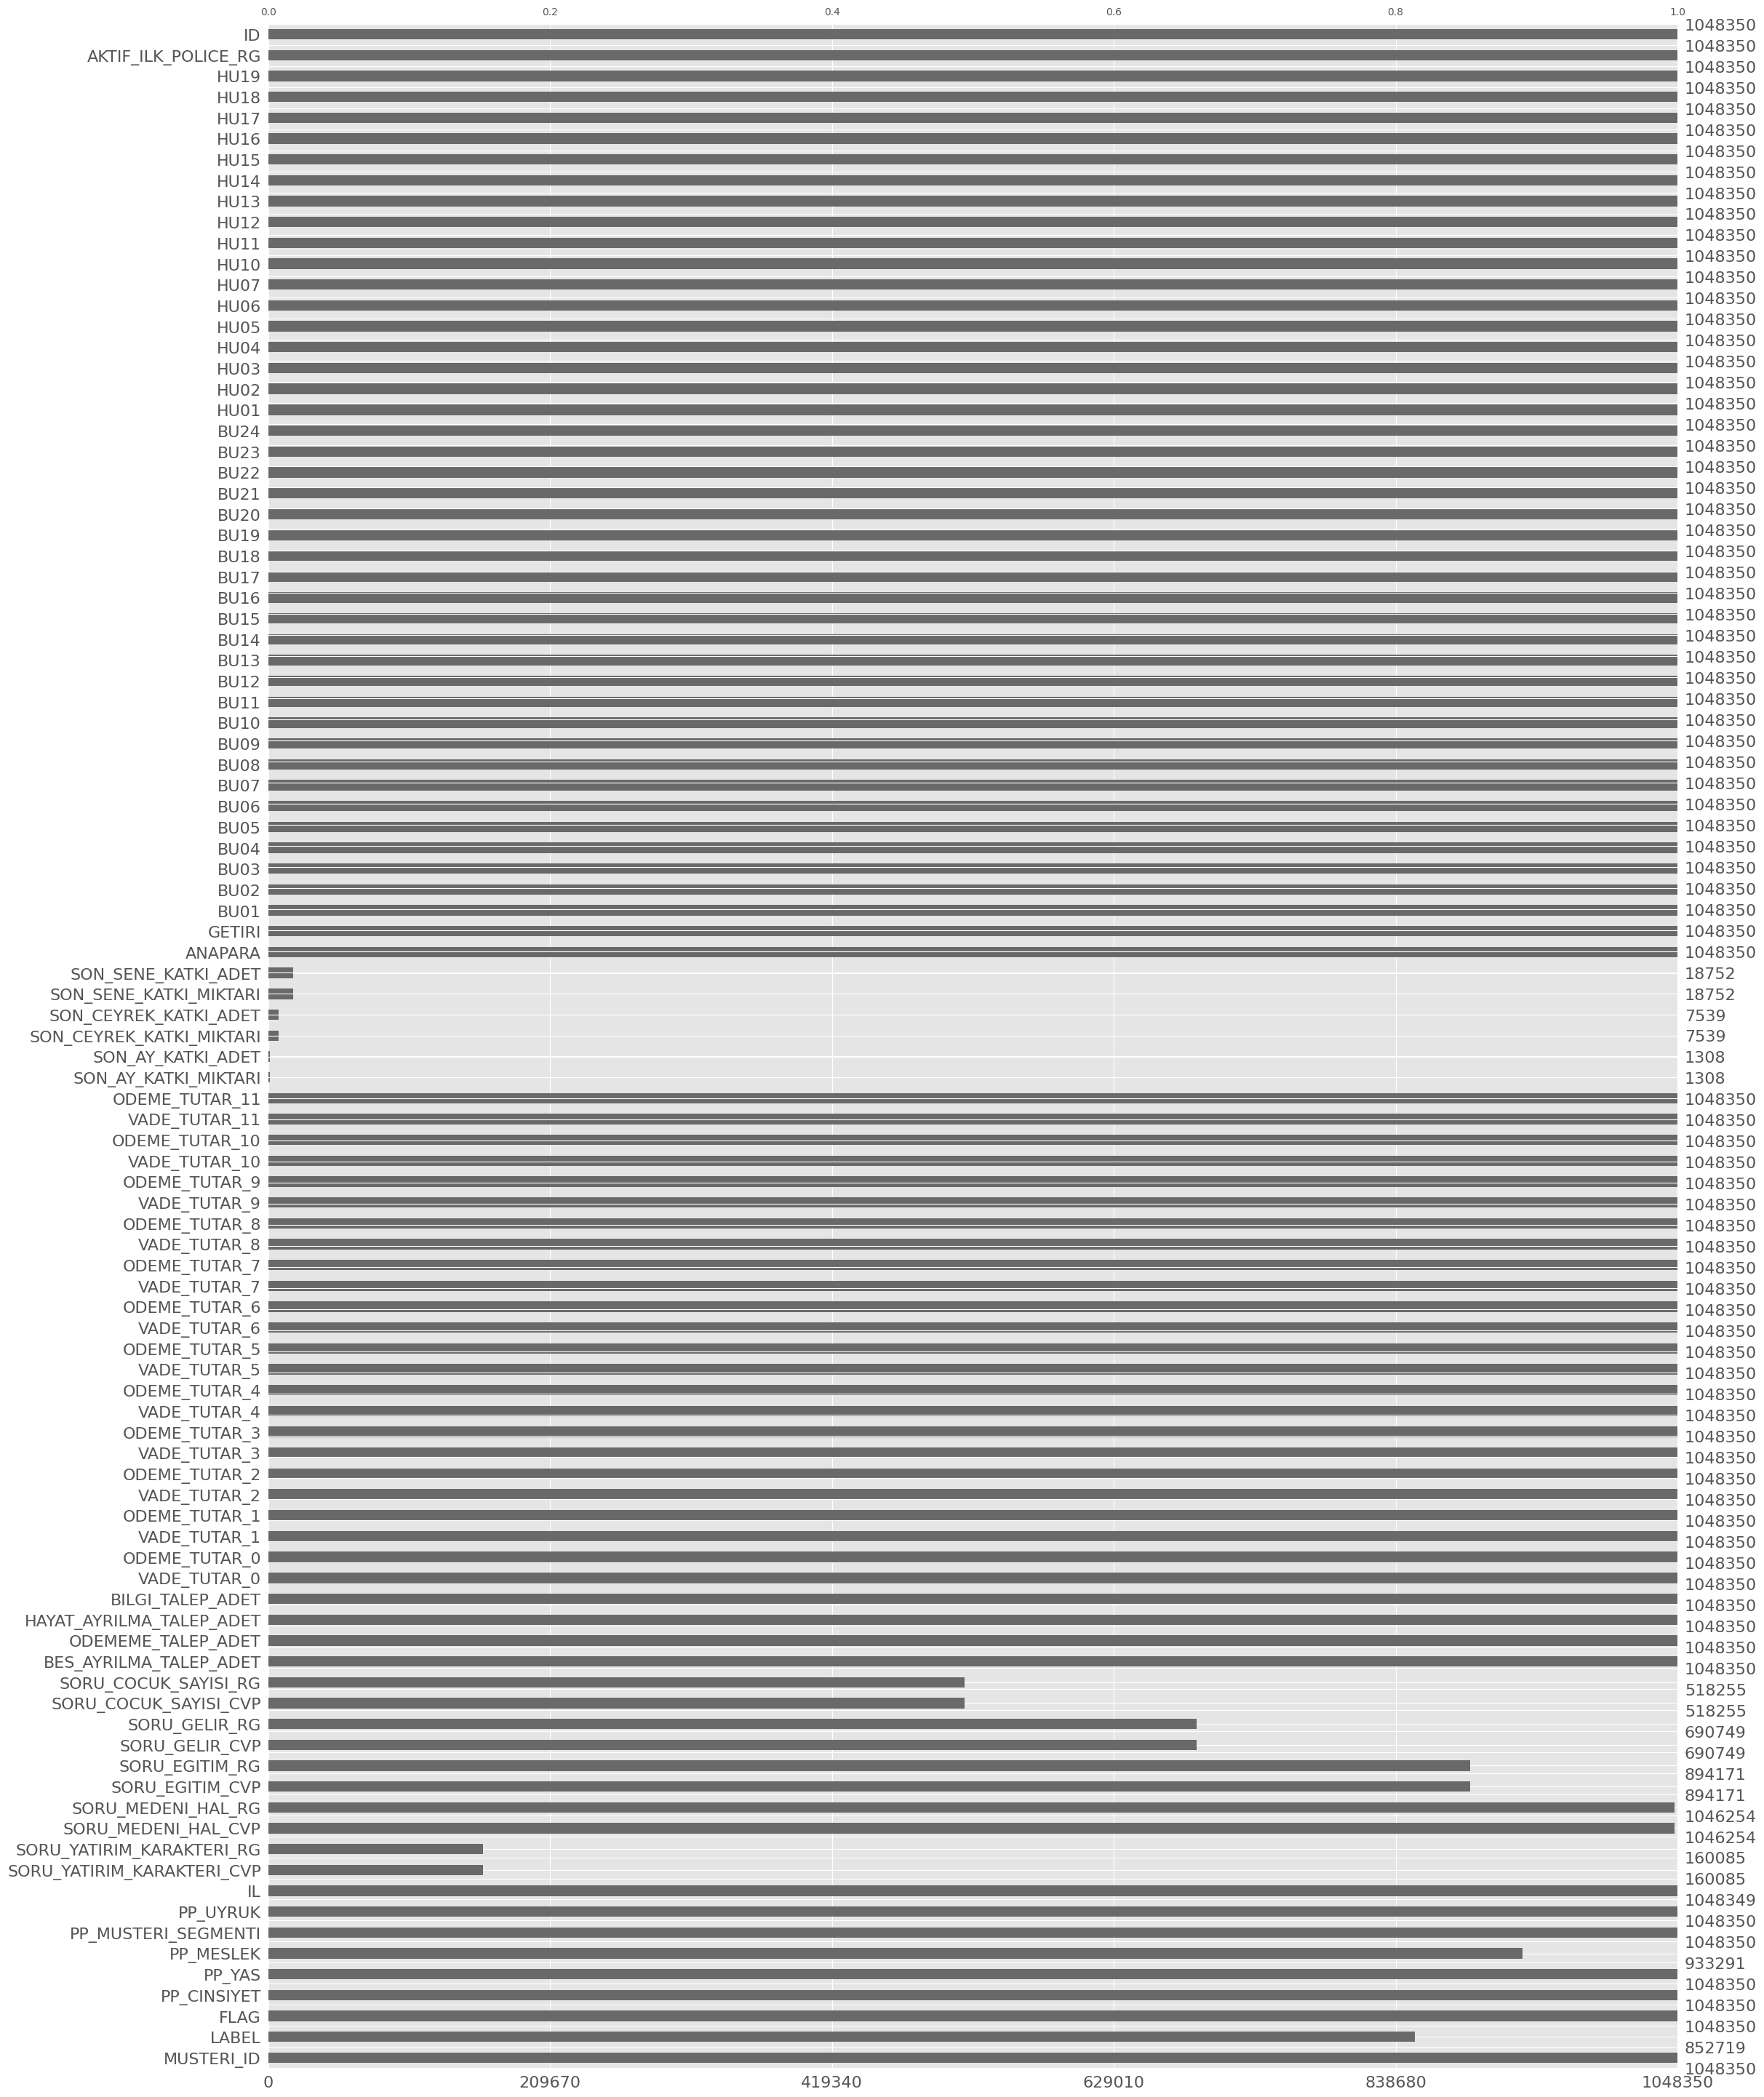

In [18]:
msno.bar(train_test_concat)

- MESLEK kısmında nan gelen verilerin neredeyse tamamında hesapta para bulunduğundan burdaki nan değerler bilinmiyor kategorisine atandı. Sadece 403 müşteride Anapara 0.

In [19]:
train_test_concat.loc[(train_test_concat["PP_MESLEK"].isnull()) & (train_test_concat["ANAPARA"]==0), ["MUSTERI_ID","ANAPARA","PP_MESLEK"]].shape

(403, 3)

In [20]:
train_test_concat["PP_MESLEK"].fillna("Bilinmiyor",inplace=True)

- 1 adet boş İL verisi en yüksek mode olan Istanbul olarak atandı. İnteger yapıldı.

In [21]:
train_test_concat.loc[train_test_concat["IL"].isnull(),["IL","MUSTERI_ID","ANAPARA"]]

IL                                                        MUSTERI_ID  \
147764 NaN  ed6d0a711152bd338496528fd921b676e47e1b7a770f09362cb1303a9e6007ca   

        ANAPARA  
147764    25327

In [22]:
train_test_concat.loc[train_test_concat["IL"].isnull(),"IL"] = 34
train_test_concat["IL"] = train_test_concat["IL"].astype(int)

- SORU_YATIRIM_KARAKTERI_CVP daki nan değerler bilinmiyor yapıldı RG dekilerde -99 atandı integera çevrildi

In [23]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].fillna("Bilinmiyor",inplace=True)
train_test_concat["SORU_YATIRIM_KARAKTERI_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_YATIRIM_KARAKTERI_RG"] = train_test_concat["SORU_YATIRIM_KARAKTERI_RG"].astype(int)

In [24]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].value_counts(dropna=False)

SORU_YATIRIM_KARAKTERI_CVP
Bilinmiyor    888265
Temkinli       41920
Cesur          40046
Dengeli        31179
Yetkin         24215
Bilge          22725
Name: count, dtype: int64

- SORU_MEDENI_HAL_CVP nan değerler Unknown kategorisine atandı rg dekilerde -99 yapıldı integera çevrildi

In [25]:
train_test_concat["SORU_MEDENI_HAL_CVP"].fillna("Unknown",inplace=True)
train_test_concat["SORU_MEDENI_HAL_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_MEDENI_HAL_RG"] = train_test_concat["SORU_MEDENI_HAL_RG"].astype(int)

In [26]:
train_test_concat["SORU_MEDENI_HAL_CVP"].value_counts(dropna=False)

SORU_MEDENI_HAL_CVP
Married               576998
Single                429275
Divorced               31516
Widowed                 8439
Unknown                 2096
Other                     16
Marriage Cancelled         8
Marriage Annulled          2
Name: count, dtype: int64

- SORU_EGITIM_CVP nan değerler Bilinmiyor kategorisine atandı rg dekilerde -99 yapıldı integera çevrildi

In [27]:
train_test_concat["SORU_EGITIM_CVP"].fillna("Bilinmiyor",inplace=True)
train_test_concat["SORU_EGITIM_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_EGITIM_RG"] = train_test_concat["SORU_EGITIM_RG"].astype(int)

In [28]:
train_test_concat["SORU_EGITIM_CVP"].value_counts(dropna=False)

SORU_EGITIM_CVP
Lise             294507
Lisans           260836
(Diğer)          171553
Bilinmiyor       154179
İlköğretim       120167
Yüksek Lisans     23033
Önlisans          19539
Doktora            4536
Name: count, dtype: int64

- SORU_COCUK_SAYISI_CVP veri setinin yarısından fazlasında eksik veri var. Bu nedenle değişkenler drop edildi. Bu durumda çocuk sayısı üzerinden yapılacak bir analiz yanıltıcı olabilir.

In [29]:
train_test_concat.drop(["SORU_COCUK_SAYISI_CVP","SORU_COCUK_SAYISI_RG"],axis=1,inplace=True)

- SON_AY_KATKI_MIKTARI, SON_AY_KATKI_ADET, SON_CEYREK_KATKI_MIKTARI, SON_CEYREK_KATKI_ADET, SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET değişkenlerindeki eksik veriler incelendiğinde nan değerler katkı olmadı anlamında kabul edilip 0 ile dolduruldu.

In [30]:
train_test_concat["SON_SENE_KATKI_MIKTARI"].value_counts(dropna=False).head()

SON_SENE_KATKI_MIKTARI
NaN       1029598
915.0        1210
457.0         880
1831.0        617
4579.0        536
Name: count, dtype: int64

In [31]:
son_columns_bool = train_test_concat.columns.str.contains("SON")
son_columns=train_test_concat.loc[:,son_columns_bool].columns
for column in son_columns:
    train_test_concat[column].fillna(0,inplace=True)
train_test_concat[son_columns]=train_test_concat[son_columns].astype(int)


**SORU_GELIR_CVP ve SORU_GELIR_RG Eksik veri işlemleri**
- Değişkende 357601 adet eksik veri vardır.
- Aykırı yazılmış değerler bulunmakdadır
- İnsanlar gelirlerini her zaman doğru şekilde yazmayabilirler. Geliri yüksek gösterme eğiliminde de olabilirler
- Bu nedenlerden dolayı yanıltıcı sonuçlar oluşabileceğinden bu değişkenleri veri setinden kaldırmak uygun görüldü.

In [32]:
train_test_concat.drop(["SORU_GELIR_CVP","SORU_GELIR_RG"],axis=1,inplace=True)

In [33]:
train_test_concat.isnull().sum()

MUSTERI_ID                         0
LABEL                         195631
FLAG                               0
PP_CINSIYET                        0
PP_YAS                             0
PP_MESLEK                          0
PP_MUSTERI_SEGMENTI                0
PP_UYRUK                           0
IL                                 0
SORU_YATIRIM_KARAKTERI_CVP         0
SORU_YATIRIM_KARAKTERI_RG          0
SORU_MEDENI_HAL_CVP                0
SORU_MEDENI_HAL_RG                 0
SORU_EGITIM_CVP                    0
SORU_EGITIM_RG                     0
BES_AYRILMA_TALEP_ADET             0
ODEMEME_TALEP_ADET                 0
HAYAT_AYRILMA_TALEP_ADET           0
BILGI_TALEP_ADET                   0
VADE_TUTAR_0                       0
ODEME_TUTAR_0                      0
VADE_TUTAR_1                       0
ODEME_TUTAR_1                      0
VADE_TUTAR_2                       0
ODEME_TUTAR_2                      0
VADE_TUTAR_3                       0
ODEME_TUTAR_3                      0
V

**DUPPLICATE KONTROLU**
- dupplicate veri bulunmamaktadır.

In [34]:
train_test_concat[train_test_concat.duplicated(keep=False)]

Empty DataFrame
Columns: [MUSTERI_ID, LABEL, FLAG, PP_CINSIYET, PP_YAS, PP_MESLEK, PP_MUSTERI_SEGMENTI, PP_UYRUK, IL, SORU_YATIRIM_KARAKTERI_CVP, SORU_YATIRIM_KARAKTERI_RG, SORU_MEDENI_HAL_CVP, SORU_MEDENI_HAL_RG, SORU_EGITIM_CVP, SORU_EGITIM_RG, BES_AYRILMA_TALEP_ADET, ODEMEME_TALEP_ADET, HAYAT_AYRILMA_TALEP_ADET, BILGI_TALEP_ADET, VADE_TUTAR_0, ODEME_TUTAR_0, VADE_TUTAR_1, ODEME_TUTAR_1, VADE_TUTAR_2, ODEME_TUTAR_2, VADE_TUTAR_3, ODEME_TUTAR_3, VADE_TUTAR_4, ODEME_TUTAR_4, VADE_TUTAR_5, ODEME_TUTAR_5, VADE_TUTAR_6, ODEME_TUTAR_6, VADE_TUTAR_7, ODEME_TUTAR_7, VADE_TUTAR_8, ODEME_TUTAR_8, VADE_TUTAR_9, ODEME_TUTAR_9, VADE_TUTAR_10, ODEME_TUTAR_10, VADE_TUTAR_11, ODEME_TUTAR_11, SON_AY_KATKI_MIKTARI, SON_AY_KATKI_ADET, SON_CEYREK_KATKI_MIKTARI, SON_CEYREK_KATKI_ADET, SON_SENE_KATKI_MIKTARI, SON_SENE_KATKI_ADET, ANAPARA, GETIRI, BU01, BU02, BU03, BU04, BU05, BU06, BU07, BU08, BU09, BU10, BU11, BU12, BU13, BU14, BU15, BU16, BU17, BU18, BU19, BU20, BU21, BU22, BU23, BU24, HU01, HU02, HU03, HU04, HU05, HU06, HU07, HU10, HU11, HU12, HU13, HU14, HU15, HU16, HU17, HU18, HU19, AKTIF_ILK_POLICE_RG, ID]
Index: []

# KEŞİFSEL VERİ ANALİZİ VE FEATURE ENGINEERING

In [35]:
def single_variable_multiple_plot(data,type="float64",numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype == type]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category","int32"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

- GETIRI VE ANAPARADA AYKIRI DEĞER TESPİTİ

In [36]:
def outlier_thresholds(dataframe, variable, q1_thr=0.25, q3_thr=0.75):
    """
    Calculate the lower and upper bounds to cap outliers in a variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the variable.
    variable : str
        The name of the variable for which to calculate the outlier thresholds.
    q1_thr : float, optional
        The quantile value for the lower quartile. Default is 0.25.
    q3_thr : float, optional
        The quantile value for the upper quartile. Default is 0.75.

    Returns
    -------
    low_limit : float
        The lower bound threshold for capping outliers.
    up_limit : float
        The upper bound threshold for capping outliers.
    """
    quartile1 = dataframe[variable].quantile(q1_thr)
    quartile3 = dataframe[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [37]:
train_test_concat[["ANAPARA","GETIRI"]].describe().T

count          mean            std       min    25%     50%  \
ANAPARA  1048350.0  17459.677132   39951.331455       0.0  952.0  4581.0   
GETIRI   1048350.0  33507.937720  114670.483848 -334227.0  484.0  2805.0   

             75%        max  
ANAPARA  17141.0   957000.0  
GETIRI   21763.0  8622932.0

In [38]:
# 100000 altındaki negatif değerler.
train_test_concat[train_test_concat["GETIRI"] < -100000].head()

MUSTERI_ID  \
760572  e626835b8bf5e34ef7dc321a2757c7ed979b9bf0a8d4b859e20c7499a4a6b90c   
784046  ad9666f40ade930ba17e889587017f655f32780b32b7cd313c509d38fd66911a   

       LABEL     FLAG  PP_CINSIYET  PP_YAS PP_MESLEK  PP_MUSTERI_SEGMENTI  \
760572    UA  HAZIRAN            1     649    Emekli                  102   
784046    UA  HAZIRAN            2     533     Memur                  102   

        PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG  \
760572         1  26                 Bilinmiyor                        -99   
784046         1  16                     Yetkin                         43   

       SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  \
760572             Married                 232            Lise   
784046             Married                 220          Lisans   

        SORU_EGITIM_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
760572             232                       0                   0   
784046             220                       0                   0   

        HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  \
760572                         0                 0          5866   
784046                         0                 0           382   

        ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  \
760572           5866          5866           5866          5866   
784046            382             0              0             0   

        ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
760572           5866          5866           5866          5866   
784046              0             0              0             0   

        ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  \
760572           5866          3349           3349          1914   
784046              0             0              0             0   

        ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  \
760572           1914          1914           1914          1914   
784046              0             0              0             0   

        ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  VADE_TUTAR_10  \
760572           1914          1914           1914           1914   
784046              0             0              0              0   

        ODEME_TUTAR_10  VADE_TUTAR_11  ODEME_TUTAR_11  SON_AY_KATKI_MIKTARI  \
760572            1914           1914            1914                     0   
784046               0              0               0                     0   

        SON_AY_KATKI_ADET  SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  \
760572                  0                         0                      0   
784046                  0                         0                      0   

        SON_SENE_KATKI_MIKTARI  SON_SENE_KATKI_ADET  ANAPARA  GETIRI  BU01  \
760572                       0                    0   529364 -334227     0   
784046                       0                    0   147793 -113536     0   

        BU02  BU03  BU04  BU05  BU06  BU07  BU08  BU09  BU10  BU11  BU12  \
760572     0     0     0     0     0     0     0     0     0     0     0   
784046     0     0     0     0     0     0     0     0     0     0     0   

        BU13  BU14  BU15  BU16  BU17  BU18  BU19  BU20  BU21  BU22  BU23  \
760572     0     0     0     0     0     0     1     0     0     0     0   
784046     1     0     0     1     0     0     0     0     0     0     0   

        BU24  HU01  HU02  HU03  HU04  HU05  HU06  HU07  HU10  HU11  HU12  \
760572     0     0     0     0     0     0     0     0     0     0     0   
784046     0     0     0     0     0     0     0     0     0     0     0   

        HU13  HU14  HU15  HU16  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG      ID  
760572     0     0     0     0     0     0     0                   16  760572  
784046     0     0     0     0     0     0     0                   12  784046

In [39]:
train_test_concat[train_test_concat["GETIRI"] < 0].shape

(66999, 94)

In [40]:
train_test_concat[train_test_concat["ANAPARA"] < 0].shape

(0, 94)

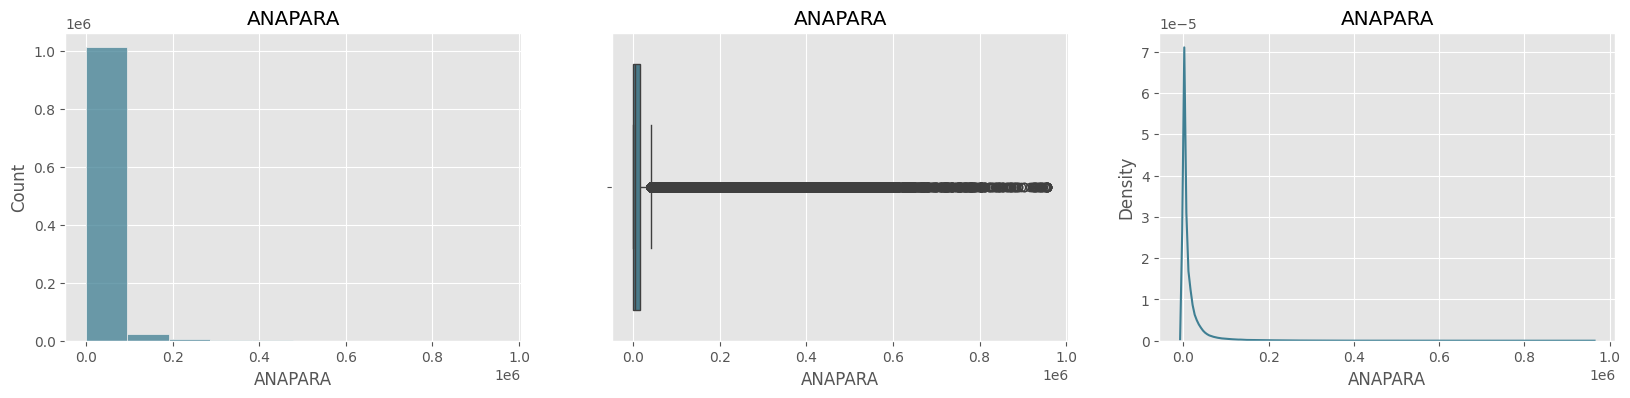

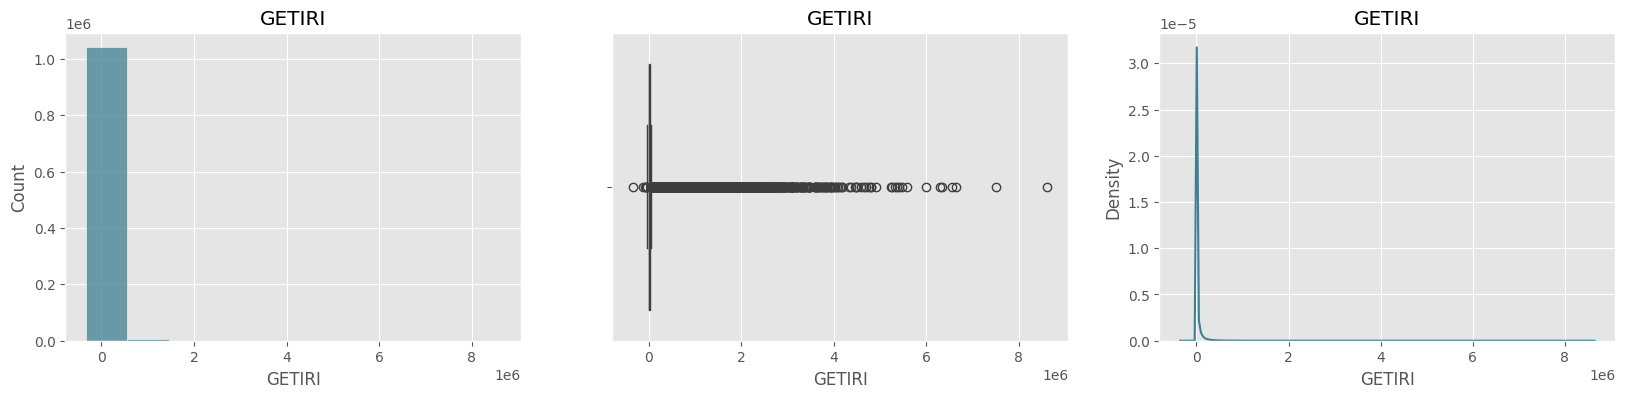

In [41]:
single_variable_multiple_plot(train_test_concat[["ANAPARA","GETIRI"]],type="int64",numeric=True)

GETİRİ 
- %4 outlier kaldırıldı

In [42]:
low_limit_getiri, up_limit_getiri = outlier_thresholds(train_test_concat,"GETIRI",q1_thr=0.04,q3_thr=0.96)

In [43]:
low_limit_getiri

-272608.11999999976

In [44]:
up_limit_getiri

454312.1999999996

In [45]:
train_test_concat[(train_test_concat["GETIRI"] < low_limit_getiri) | (train_test_concat["GETIRI"] > up_limit_getiri)].shape

(11551, 94)

In [46]:
# Aykırı değer baskılama
train_test_concat.loc[(train_test_concat["GETIRI"] > up_limit_getiri), "GETIRI"] = up_limit_getiri
train_test_concat.loc[(train_test_concat["GETIRI"] < low_limit_getiri), "GETIRI"] = low_limit_getiri

ANAPARA

In [47]:
low_limit_anapara, up_limit_anapara = outlier_thresholds(train_test_concat,"ANAPARA",q1_thr=0.01,q3_thr=0.99)

In [48]:
low_limit_anapara

-302759.53

In [49]:
up_limit_anapara

504604.55000000005

In [50]:
train_test_concat[train_test_concat["ANAPARA"] > up_limit_anapara].shape

(610, 94)

In [51]:
# Aykırı değer baskılama
train_test_concat.loc[(train_test_concat["ANAPARA"] > up_limit_anapara), "ANAPARA"] = up_limit_anapara

In [52]:
train_test_concat[["ANAPARA","GETIRI"]].describe().T

count          mean           std        min    25%     50%  \
ANAPARA  1048350.0  17376.684986  38669.054217       0.00  952.0  4581.0   
GETIRI   1048350.0  29226.010204  70654.498936 -272608.12  484.0  2805.0   

             75%        max  
ANAPARA  17141.0  504604.55  
GETIRI   21763.0  454312.20

In [53]:
train_test_concat[["ANAPARA","GETIRI"]] = train_test_concat[["ANAPARA","GETIRI"]].astype("int64")

In [54]:
train_test_concat[["ANAPARA","GETIRI"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048350 entries, 0 to 195630
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   ANAPARA  1048350 non-null  int64
 1   GETIRI   1048350 non-null  int64
dtypes: int64(2)
memory usage: 24.0 MB


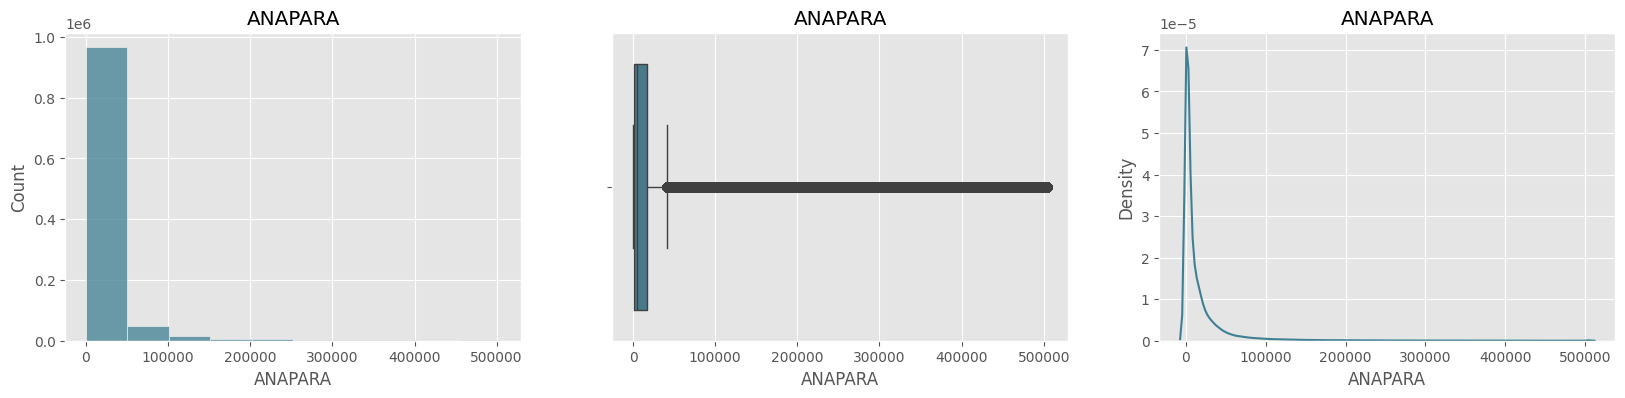

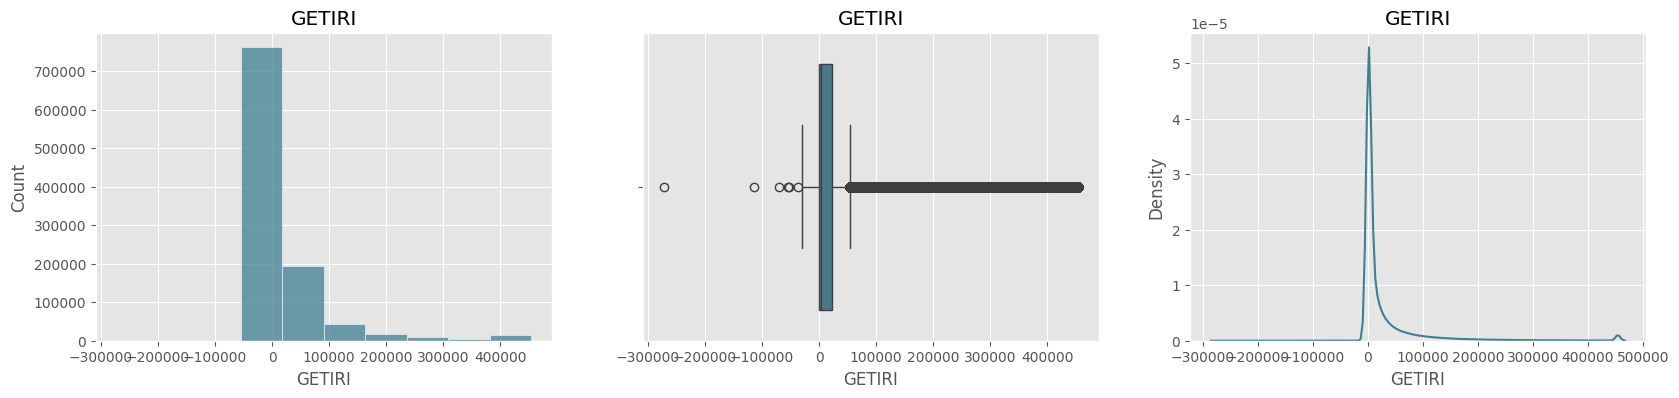

In [55]:
single_variable_multiple_plot(train_test_concat[["ANAPARA","GETIRI"]],type="int64",numeric=True)

**ANAPARA VE GETİRİ KATEGORİK DEĞİŞKEN OLUŞTURULMASI**

In [56]:
train_test_concat[["ANAPARA","GETIRI"]].describe().T

count          mean           std       min    25%     50%  \
ANAPARA  1048350.0  17376.684666  38669.050185       0.0  952.0  4581.0   
GETIRI   1048350.0  29226.008000  70654.485679 -272608.0  484.0  2805.0   

             75%       max  
ANAPARA  17141.0  504604.0  
GETIRI   21763.0  454312.0

In [57]:
labels=["Very Low", "Low", "Medium", "High", "Very High"]
bins=[-np.inf, 952, 4581, 17141, 45925, np.inf]
train_test_concat["ANAPARA_KATEGORI"] = pd.cut(train_test_concat["ANAPARA"],bins=bins, labels=labels)
train_test_concat["ANAPARA_KATEGORI"].value_counts()

ANAPARA_KATEGORI
Very Low     262600
Medium       262051
Low          261620
High         168657
Very High     93422
Name: count, dtype: int64

In [58]:
labels=["Very Low", "Low", "Medium", "High", "Very High"]
bins=[-np.inf, 0, 5000, 20000, 80000, np.inf]
train_test_concat["GETIRI_KATEGORI"] = pd.cut(train_test_concat["GETIRI"],bins=bins, labels=labels)
train_test_concat["GETIRI_KATEGORI"].value_counts()

GETIRI_KATEGORI
Low          524859
Medium       174337
High         169392
Very High    104159
Very Low      75603
Name: count, dtype: int64

**PP_YAS AYLIKTAN NORMAL YAŞA ÇEVRİLDİ**

In [59]:
train_test_concat["PP_YAS"] = train_test_concat["PP_YAS"] // 12

In [60]:
train_test_concat[["PP_YAS"]].describe().T

count       mean        std  min   25%   50%   75%    max
PP_YAS  1048350.0  35.863539  17.211487  0.0  25.0  38.0  48.0  122.0

In [61]:
train_test_concat[["PP_YAS"]].dtypes

PP_YAS    int64
dtype: object

<Axes: >

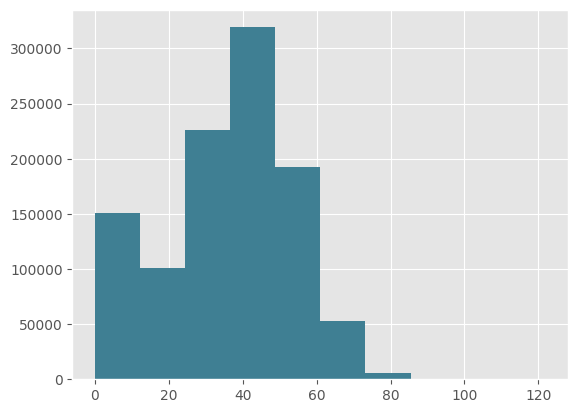

In [62]:
train_test_concat["PP_YAS"].hist()

In [63]:
train_test_concat.loc[train_test_concat["PP_YAS"] > 100, "PP_YAS"].shape

(4,)

In [64]:
train_test_concat.loc[(train_test_concat["BU02"] > 0) & (train_test_concat["PP_YAS"] < 18) , ["MUSTERI_ID","PP_YAS","BU02"]].head(10)

MUSTERI_ID  \
780891  d9bdca7397a363b589ede76a0548bc6dcc9931109c7e23770709433d5c91f5ea   

        PP_YAS  BU02  
780891      17     1

**ÜRÜN ÖZELLİKLERİNDEKİ VERİLERE GÖRE ŞİRKETİN TANIMLADIĞI YAŞ ARALIKLARI EKLENDİ**

In [65]:
train_test_concat["PP_18_25_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 50), 1,0)
train_test_concat["PP_0_18_YAS"] = np.where((train_test_concat["PP_YAS"] > 0) & (train_test_concat["PP_YAS"] <= 18), 1,0)
train_test_concat["PP_18_60_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 60), 1,0)
train_test_concat["PP_18_65_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 65), 1,0)
train_test_concat["PP_18_70_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 70), 1,0)
train_test_concat["PP_16_70_YAS"] = np.where((train_test_concat["PP_YAS"] >= 16) & (train_test_concat["PP_YAS"] <= 70), 1,0)
train_test_concat["PP_0_15_YAS"] = np.where((train_test_concat["PP_YAS"] > 0) & (train_test_concat["PP_YAS"] <= 15), 1,0)
train_test_concat["PP_18_64_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 64), 1,0)
train_test_concat["PP_18_50_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 50), 1,0)
train_test_concat["PP_18_69_YAS"] = np.where((train_test_concat["PP_YAS"] >= 18) & (train_test_concat["PP_YAS"] <= 69), 1,0)


**BIREYSEL EMEKLİLİK VE HAYAT ÜRÜNLERİNİN İNCELENMESİ**

In [66]:
train_test_concat.head()

MUSTERI_ID LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    UA   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    UA   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f  HU19   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    UA   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    UA   

      FLAG  PP_CINSIYET  PP_YAS                                   PP_MESLEK  \
0  HAZIRAN            2      42                                    Öğretmen   
1  HAZIRAN            2      74  Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)   
2  HAZIRAN            2      48                                    Muhasebe   
3    MAYIS            2      54                                       Diğer   
4    EYLUL            2      40                                        İşçi   

   PP_MUSTERI_SEGMENTI  PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP  \
0                  105         1  34                 Bilinmiyor   
1                  102         1  20                 Bilinmiyor   
2                  104         1   6                     Yetkin   
3                  106         1  34                 Bilinmiyor   
4                  103         1  77                 Bilinmiyor   

   SORU_YATIRIM_KARAKTERI_RG SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  \
0                        -99              Single                  68   
1                        -99             Married                  11   
2                         26              Single                 235   
3                        -99             Married                 111   
4                        -99             Married                  91   

  SORU_EGITIM_CVP  SORU_EGITIM_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
0         (Diğer)              68                       0                   0   
1      İlköğretim              11                       0                   0   
2          Lisans             235                       0                   0   
3            Lise             111                       0                   0   
4          Lisans              91                       0                   0   

   HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  \
0                         0                 0           405            405   
1                         0                 0          5720           5720   
2                         0                 0          1172           1172   
3                         0                 0           574              0   
4                         0                 0           459              0   

   VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  \
0           405            405           405            405           405   
1          5720           5720          4763           4763          4763   
2          1172           1172          1172           1172          1172   
3           574              0           574              0           574   
4           459              0           459              0           459   

   ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  \
0            405           405            405           220            220   
1           4763          4763           4763          2871           2871   
2           1172          1172           1172           631            631   
3              0           306              0           306              0   
4            459           459            459           459            459   

   VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  \
0           220            220           220            220           220   
1          2871           2871          2871           2871          2871   
2           631            631           631            631           631   
3           306              0           306              0           306   
4         

In [67]:
BU_total=train_test_concat.loc[:, train_test_concat.columns.str.contains("BU")].sum().reset_index()

- En çok tercih edilen bireysel emeklilik ürünleri; BU09, BU17, BU23' dir.

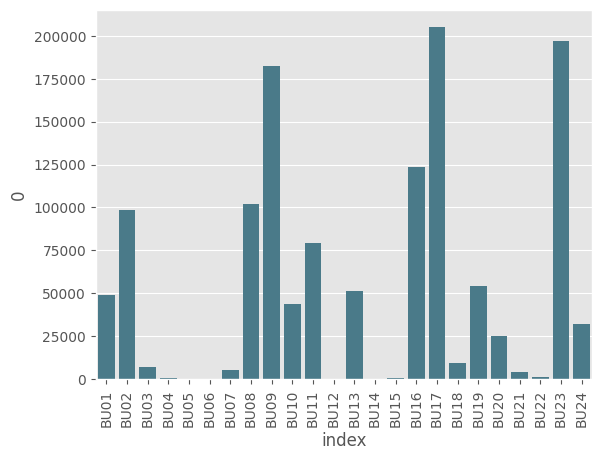

In [68]:
sns.barplot(x="index",y=0, data=BU_total)
plt.xticks(rotation=90)
plt.show()

In [69]:
HU_total=train_test_concat.loc[:, train_test_concat.columns.str.contains("HU")].sum().reset_index()

- En çok tercih edilen hayat sigortası ürünleri, HU06, HU14 ve HU18'dir.

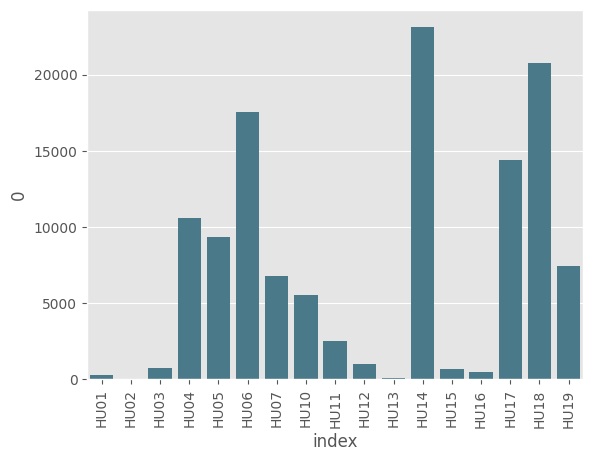

In [70]:
sns.barplot(x="index",y=0, data=HU_total)
plt.xticks(rotation=90)
plt.show()

**MUSTERI BAZLI TOPLAM BES ÜRÜN TOPLAM HAYAT ÜRÜN KOLONLARININ EKLENMESİ**
- BU KISMI TEKRAER İNCELE!

In [71]:
train_test_concat["TOPLAM_BES_URUN"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("BU")].sum(axis=1)
train_test_concat["TOPLAM_HAYAT_URUN"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("HU")].sum(axis=1)
train_test_concat[["MUSTERI_ID","TOPLAM_BES_URUN","TOPLAM_HAYAT_URUN","ANAPARA","GETIRI"]].head()

MUSTERI_ID  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491   

   TOPLAM_BES_URUN  TOPLAM_HAYAT_URUN  ANAPARA  GETIRI  
0                1                  0     2654     132  
1                2                  0    62945   75370  
2                2                  1    22929   16055  
3                1                  0      178     497  
4                1                  0     1378    1151

In [72]:
train_test_concat["LABEL"].value_counts()

LABEL
UA      832770
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [73]:
train_test_concat.loc[:, train_test_concat.columns.str.contains("HU")].sum().reset_index()

index      0
0   HU01    315
1   HU02     21
2   HU03    769
3   HU04  10621
4   HU05   9322
5   HU06  17537
6   HU07   6798
7   HU10   5513
8   HU11   2532
9   HU12    995
10  HU13    109
11  HU14  23098
12  HU15    718
13  HU16    463
14  HU17  14427
15  HU18  20755
16  HU19   7423

In [74]:
train_test_concat.loc[:, train_test_concat.columns.str.contains("BU")].sum().reset_index()

index       0
0   BU01   48966
1   BU02   98305
2   BU03    6962
3   BU04     725
4   BU05     327
5   BU06       3
6   BU07    5285
7   BU08  102146
8   BU09  182550
9   BU10   43872
10  BU11   79115
11  BU12      10
12  BU13   51133
13  BU14     375
14  BU15     976
15  BU16  123713
16  BU17  204951
17  BU18    9424
18  BU19   54546
19  BU20   25018
20  BU21    4323
21  BU22    1115
22  BU23  196935
23  BU24   32438

**Bes ve hayat ürünleri grafik ve adetlere bakılarak incelenmiştir. Ayrıca silme işlemi uygulamadan önce bütün veri ile logistic regresyon ve xgboost eğitilmiştir ve seçilen özelliklere bakılmıştır. Buna göre az veri olan bes ve hayat ürünleri değişkenleri model karmaşıklığını azaltmak için veri setinden çıkarılmıştır.**

In [75]:
train_test_concat.drop(["HU01","HU02","HU03","HU13","HU16","BU04","BU05","BU06","BU12","BU14","BU15","BU22"],axis=1,inplace=True)

In [76]:
train_test_concat.loc[train_test_concat["LABEL"]=="HU15",["LABEL","TOPLAM_BES_URUN","TOPLAM_HAYAT_URUN"]].head()

LABEL  TOPLAM_BES_URUN  TOPLAM_HAYAT_URUN
139   HU15                1                  1
282   HU15                2                  2
2875  HU15                1                  1
4331  HU15                1                  1
4474  HU15                2                  1

In [77]:
train_test_concat.head()

MUSTERI_ID LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    UA   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    UA   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f  HU19   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    UA   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    UA   

      FLAG  PP_CINSIYET  PP_YAS                                   PP_MESLEK  \
0  HAZIRAN            2      42                                    Öğretmen   
1  HAZIRAN            2      74  Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)   
2  HAZIRAN            2      48                                    Muhasebe   
3    MAYIS            2      54                                       Diğer   
4    EYLUL            2      40                                        İşçi   

   PP_MUSTERI_SEGMENTI  PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP  \
0                  105         1  34                 Bilinmiyor   
1                  102         1  20                 Bilinmiyor   
2                  104         1   6                     Yetkin   
3                  106         1  34                 Bilinmiyor   
4                  103         1  77                 Bilinmiyor   

   SORU_YATIRIM_KARAKTERI_RG SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  \
0                        -99              Single                  68   
1                        -99             Married                  11   
2                         26              Single                 235   
3                        -99             Married                 111   
4                        -99             Married                  91   

  SORU_EGITIM_CVP  SORU_EGITIM_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
0         (Diğer)              68                       0                   0   
1      İlköğretim              11                       0                   0   
2          Lisans             235                       0                   0   
3            Lise             111                       0                   0   
4          Lisans              91                       0                   0   

   HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  \
0                         0                 0           405            405   
1                         0                 0          5720           5720   
2                         0                 0          1172           1172   
3                         0                 0           574              0   
4                         0                 0           459              0   

   VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  \
0           405            405           405            405           405   
1          5720           5720          4763           4763          4763   
2          1172           1172          1172           1172          1172   
3           574              0           574              0           574   
4           459              0           459              0           459   

   ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  \
0            405           405            405           220            220   
1           4763          4763           4763          2871           2871   
2           1172          1172           1172           631            631   
3              0           306              0           306              0   
4            459           459            459           459            459   

   VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  \
0           220            220           220            220           220   
1          2871           2871          2871           2871          2871   
2           631            631           631            631           631   
3           306              0           306              0           306   
4         

**BES_AYRILMA_TALEP_ADET	ODEMEME_TALEP_ADET	HAYAT_AYRILMA_TALEP_ADET	BILGI_TALEP_ADET**
- Bunlar kalıcak

In [78]:
train_test_concat["BES_AYRILMA_TALEP_ADET"].value_counts()

BES_AYRILMA_TALEP_ADET
0     1038717
1        8512
2         969
3         112
4          32
5           4
7           1
8           1
6           1
15          1
Name: count, dtype: int64

**SON_AY_KATKI_MIKTARI	SON_AY_KATKI_ADET	SON_CEYREK_KATKI_MIKTARI	SON_CEYREK_KATKI_ADET	SON_SENE_KATKI_MIKTARI	SON_SENE_KATKI_ADET**
- Bunlarda kalıcak

In [79]:
train_test_concat["SON_AY_KATKI_MIKTARI"].value_counts().head()

SON_AY_KATKI_MIKTARI
0    1047044
4        133
5         85
6         68
3         53
Name: count, dtype: int64

**MUSTERI BAZLI TOPLAM ODEME TUTAR TOPLAM VADE TUTAR KOLONLARININ EKLENMESİ**

In [80]:
train_test_concat["TOPLAM_OD_TUTAR"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("ODEME_TUTAR")].sum(axis=1)
train_test_concat["TOPLAM_VAD_TUTAR"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("VADE_TUTAR")].sum(axis=1)
train_test_concat[["MUSTERI_ID","TOPLAM_OD_TUTAR","TOPLAM_VAD_TUTAR","ANAPARA","GETIRI"]].head()

MUSTERI_ID  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491   

   TOPLAM_OD_TUTAR  TOPLAM_VAD_TUTAR  ANAPARA  GETIRI  
0             3125              3125     2654     132  
1            41998             40084    62945   75370  
2            10277             10277    22929   16055  
3                0              4744      178     497  
4             1377              4664     1378    1151

**VADESINI TAM ODEYEN MÜŞTERİ ÖZELLİKĞİ EKLENDİ**


In [81]:
train_test_concat["TAM_ODEME"] = np.where(train_test_concat["TOPLAM_OD_TUTAR"]==train_test_concat["TOPLAM_VAD_TUTAR"],1,0)

- Tam ödeme yapan müşteri sayısı

In [82]:
train_test_concat["TAM_ODEME"].sum()

581739

In [83]:
train_test_concat.head()

MUSTERI_ID LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    UA   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    UA   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f  HU19   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    UA   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    UA   

      FLAG  PP_CINSIYET  PP_YAS                                   PP_MESLEK  \
0  HAZIRAN            2      42                                    Öğretmen   
1  HAZIRAN            2      74  Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)   
2  HAZIRAN            2      48                                    Muhasebe   
3    MAYIS            2      54                                       Diğer   
4    EYLUL            2      40                                        İşçi   

   PP_MUSTERI_SEGMENTI  PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP  \
0                  105         1  34                 Bilinmiyor   
1                  102         1  20                 Bilinmiyor   
2                  104         1   6                     Yetkin   
3                  106         1  34                 Bilinmiyor   
4                  103         1  77                 Bilinmiyor   

   SORU_YATIRIM_KARAKTERI_RG SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  \
0                        -99              Single                  68   
1                        -99             Married                  11   
2                         26              Single                 235   
3                        -99             Married                 111   
4                        -99             Married                  91   

  SORU_EGITIM_CVP  SORU_EGITIM_RG  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  \
0         (Diğer)              68                       0                   0   
1      İlköğretim              11                       0                   0   
2          Lisans             235                       0                   0   
3            Lise             111                       0                   0   
4          Lisans              91                       0                   0   

   HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  \
0                         0                 0           405            405   
1                         0                 0          5720           5720   
2                         0                 0          1172           1172   
3                         0                 0           574              0   
4                         0                 0           459              0   

   VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  \
0           405            405           405            405           405   
1          5720           5720          4763           4763          4763   
2          1172           1172          1172           1172          1172   
3           574              0           574              0           574   
4           459              0           459              0           459   

   ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  \
0            405           405            405           220            220   
1           4763          4763           4763          2871           2871   
2           1172          1172           1172           631            631   
3              0           306              0           306              0   
4            459           459            459           459            459   

   VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  \
0           220            220           220            220           220   
1          2871           2871          2871           2871          2871   
2           631            631           631            631           631   
3           306              0           306              0           306   
4         

**EĞİTİM VE CİNSİYETE GÖRE ANAPARA DAĞILIMLARI**

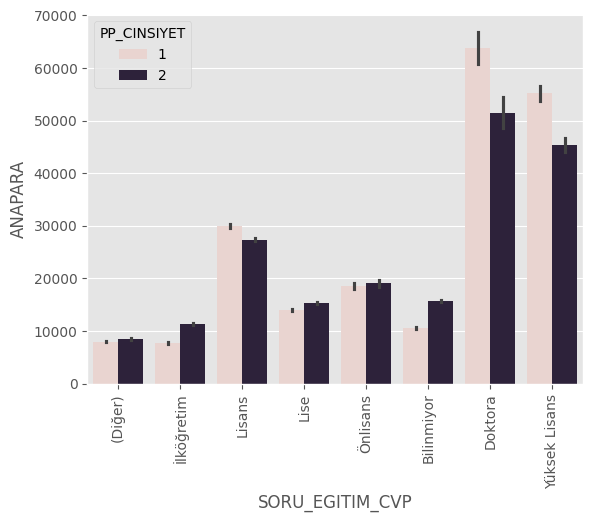

In [84]:
sns.barplot(x="SORU_EGITIM_CVP",y="ANAPARA",hue="PP_CINSIYET",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

# VERİ ÖN İŞLEME

**LABEL değişkeni label encoding yapıldı**

In [85]:
train_test_concat.head(1)

MUSTERI_ID LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    UA   

      FLAG  PP_CINSIYET  PP_YAS PP_MESLEK  PP_MUSTERI_SEGMENTI  PP_UYRUK  IL  \
0  HAZIRAN            2      42  Öğretmen                  105         1  34   

  SORU_YATIRIM_KARAKTERI_CVP  SORU_YATIRIM_KARAKTERI_RG SORU_MEDENI_HAL_CVP  \
0                 Bilinmiyor                        -99              Single   

   SORU_MEDENI_HAL_RG SORU_EGITIM_CVP  SORU_EGITIM_RG  BES_AYRILMA_TALEP_ADET  \
0                  68         (Diğer)              68                       0   

   ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  \
0                   0                         0                 0   

   VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  \
0           405            405           405            405           405   

   ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  \
0            405           405            405           405            405   

   VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  \
0           220            220           220            220           220   

   ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  \
0            220           220            220           220            220   

   VADE_TUTAR_10  ODEME_TUTAR_10  VADE_TUTAR_11  ODEME_TUTAR_11  \
0              0               0              0               0   

   SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  SON_CEYREK_KATKI_MIKTARI  \
0                     0                  0                         0   

   SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  SON_SENE_KATKI_ADET  \
0                      0                       0                    0   

   ANAPARA  GETIRI  BU01  BU02  BU03  BU07  BU08  BU09  BU10  BU11  BU13  \
0     2654     132     1     0     0     0     0     0     0     0     0   

   BU16  BU17  BU18  BU19  BU20  BU21  BU23  BU24  HU04  HU05  HU06  HU07  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   HU10  HU11  HU12  HU14  HU15  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG  ID  \
0     0     0     0     0     0     0     0     0                    9   0   

  ANAPARA_KATEGORI GETIRI_KATEGORI  PP_18_25_YAS  PP_0_18_YAS  PP_18_60_YAS  \
0              Low             Low             1            0             1   

   PP_18_65_YAS  PP_18_70_YAS  PP_16_70_YAS  PP_0_15_YAS  PP_18_64_YAS  \
0             1             1             1            0             1   

   PP_18_50_YAS  PP_18_69_YAS  TOPLAM_BES_URUN  TOPLAM_HAYAT_URUN  \
0             1             1                1                  0   

   TOPLAM_OD_TUTAR  TOPLAM_VAD_TUTAR  TAM_ODEME  
0             3125              3125          1

In [86]:
train_test_concat["LABEL"].value_counts(dropna=False)

LABEL
UA      832770
NaN     195631
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [87]:
train_test_concat["LABEL"] = train_test_concat["LABEL"].astype("category")
train_test_concat["LABEL"] = train_test_concat["LABEL"].cat.codes

In [88]:
train_test_concat["LABEL"].value_counts(dropna=False)

LABEL
 7    832770
-1    195631
 4     10754
 1      3728
 0      3178
 6       759
 3       676
 2       439
 5       415
Name: count, dtype: int64

**FLAG değişkeni AY olarak değiştirilip sayısal yapıldı**

In [89]:
train_test_concat["FLAG"].value_counts(dropna=False)

FLAG
HAZIRAN    252193
MAYIS      246389
ARALIK     109478
EKIM        93766
EYLUL       89170
TEMMUZ      86460
KASIM       86153
AGUSTOS     84741
Name: count, dtype: int64

In [90]:
train_test_concat["AY"] = train_test_concat["FLAG"].replace({"HAZIRAN":6,"MAYIS":5,"ARALIK":12,"EKIM":10,"EYLUL":9,"TEMMUZ":7,"KASIM":11,"AGUSTOS":8})
train_test_concat.drop("FLAG",axis=1,inplace=True)

In [91]:
train_test_concat["AY"].value_counts(dropna=False)

AY
6     252193
5     246389
12    109478
10     93766
9      89170
7      86460
11     86153
8      84741
Name: count, dtype: int64

**PP_CINSIYET binary kodlandı erkek 1 yine 1, kadın 0 olarak değiştirildi.**

In [92]:
train_test_concat["PP_CINSIYET"].value_counts()

PP_CINSIYET
1    532907
2    515443
Name: count, dtype: int64

In [93]:
train_test_concat["PP_CINSIYET"] = np.where(train_test_concat["PP_CINSIYET"]==1, 1, 0)

In [94]:
train_test_concat["PP_CINSIYET"].value_counts()

PP_CINSIYET
1    532907
0    515443
Name: count, dtype: int64

**PP_MESLEK kardinalite çok yüksek olduğundan frekans tabanlı ve smooth mean target encoding ile kodlandı**
- Frekans Encoding

In [95]:
train_test_concat["PP_MESLEK"].nunique()

114

In [96]:
train_test_concat["PP_MESLEK"].value_counts()

PP_MESLEK
İşçi                                          170189
Öğrenci                                       128304
Ev Hanımı                                     122378
Bilinmiyor                                    117991
Diğer                                         114750
Öğretmen                                       41559
Esnaf                                          36383
Memur                                          35624
Serbest Meslek                                 31944
Mühendis                                       22807
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)     15447
Danışman                                       10826
Emekli                                         10415
SSK-Sosyal Sigortalar Kurumu Emeklileri         9731
Tacir ve Esnaf                                  9412
Akademisyen                                     8979
Banka                                           8608
Ordu Mensubu                                    8607
Hizmet Çalışanı                     

In [97]:
frequencies = train_test_concat["PP_MESLEK"].value_counts().to_dict()
train_test_concat["PP_MESLEK_FREKANS"] = train_test_concat["PP_MESLEK"].map(frequencies)

- Smooth Mean Target Encoding
- Df yi ilk olarak train test olarak ayırıp smooth mean target encoding uygulandı.

In [98]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

In [99]:
def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

In [100]:
def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

In [101]:
new_train = train_test_concat[train_test_concat["ID"].isin(train["ID"])]
new_test = train_test_concat[train_test_concat["ID"].isin(test["ID"])]
new_test["LABEL"]=np.nan

In [102]:
# Create mean target encoded feature
new_train["PP_MESLEK_ENC"], new_test["PP_MESLEK_ENC"] = mean_target_encoding(train=new_train,test=new_test,target="LABEL",categorical="PP_MESLEK", alpha=10)

In [103]:
print(new_test[['PP_MESLEK', 'PP_MESLEK_ENC']].drop_duplicates())

                                         PP_MESLEK  PP_MESLEK_ENC
0                                         Öğretmen       6.895893
2                                   Serbest Meslek       6.963432
3                                       Bilinmiyor       6.984486
4                                          Öğrenci       6.948999
5                                             İşçi       6.867658
7                                        Ev Hanımı       6.913596
12                                           Diğer       6.985432
15                                          Emekli       6.887034
16                                        Mühendis       6.903872
22                                        İş Adamı       6.837249
28                                        Muhasebe       6.838082
31                                           Banka       6.786086
33                                           Memur       6.891641
41                                 Hizmet Çalışanı       6.569401
44        

- Tekrar train ve test birleştirildi PP_MESLEK drop edildi.

In [104]:
train_test_concat = pd.concat([new_train,new_test],axis=0)
train_test_concat.drop("PP_MESLEK",axis=1, inplace=True)

**PP_MUSTERI_SEGMENTI ordinal kodlandı**
- 101 A segmente öncelik verildi sıralama ona göre devam etti

In [105]:
train_test_concat["PP_MUSTERI_SEGMENTI"].value_counts().sort_index()

PP_MUSTERI_SEGMENTI
101       977
102    131099
103    107090
104    106951
105    251988
106    450245
Name: count, dtype: int64

In [106]:
categories = [106,105,104,103,102,101]
train_test_concat["PP_MUSTERI_SEGMENTI"] = pd.Categorical(train_test_concat["PP_MUSTERI_SEGMENTI"], categories=categories,ordered=True)
train_test_concat["PP_MUSTERI_SEGMENTI"].dtypes

CategoricalDtype(categories=[106, 105, 104, 103, 102, 101], ordered=True, categories_dtype=int64)

In [107]:
train_test_concat["PP_MUSTERI_SEGMENTI"] = train_test_concat["PP_MUSTERI_SEGMENTI"].cat.codes
train_test_concat["PP_MUSTERI_SEGMENTI"].value_counts().sort_index()

PP_MUSTERI_SEGMENTI
0    450245
1    251988
2    106951
3    107090
4    131099
5       977
Name: count, dtype: int64

**PP_UYRUK one hot encoding ile kodlandı**

In [108]:
train_test_concat["PP_UYRUK"].value_counts()

PP_UYRUK
1    1042888
2       3077
3       2385
Name: count, dtype: int64

In [109]:
category_one_hot = pd.get_dummies(train_test_concat["PP_UYRUK"]).astype(int)
train_test_concat.drop("PP_UYRUK", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)
train_test_concat.rename(columns={1:"TC_VAT",2:"MAVIKART",3:"YABANCI"},inplace=True)

**SORU_YATIRIM_KARAKTERI_CVP one hot encoding ile kodlandı**

In [110]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].value_counts()

SORU_YATIRIM_KARAKTERI_CVP
Bilinmiyor    888265
Temkinli       41920
Cesur          40046
Dengeli        31179
Yetkin         24215
Bilge          22725
Name: count, dtype: int64

In [111]:
category_one_hot = pd.get_dummies(train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"],prefix="YK").astype(int)
train_test_concat.drop("SORU_YATIRIM_KARAKTERI_CVP", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)

**SORU_MEDENI_HAL_CVP binary encoding ile kodlandı. Veri setitnin büyük çoğunluğunu single ve married oluşturuyor divorced ve diğerleride single kategorisine alındı**

In [112]:
train_test_concat["SORU_MEDENI_HAL_CVP"].value_counts()

SORU_MEDENI_HAL_CVP
Married               576998
Single                429275
Divorced               31516
Widowed                 8439
Unknown                 2096
Other                     16
Marriage Cancelled         8
Marriage Annulled          2
Name: count, dtype: int64

In [113]:
train_test_concat["SORU_MEDENI_HAL_CVP"] = np.where(train_test_concat["SORU_MEDENI_HAL_CVP"] == "Married", 1, 0)

**SORU_EGITIM_CVP one hot encoding ile kodlandı**

In [114]:
train_test_concat["SORU_EGITIM_CVP"].value_counts()

SORU_EGITIM_CVP
Lise             294507
Lisans           260836
(Diğer)          171553
Bilinmiyor       154179
İlköğretim       120167
Yüksek Lisans     23033
Önlisans          19539
Doktora            4536
Name: count, dtype: int64

In [115]:
category_one_hot = pd.get_dummies(train_test_concat["SORU_EGITIM_CVP"],prefix="EGITIM_").astype(int)
train_test_concat.drop("SORU_EGITIM_CVP", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)
train_test_concat.head()

MUSTERI_ID  LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    7.0   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    7.0   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f    6.0   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    7.0   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    7.0   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      42                    1  34                        -99   
1            0      74                    4  20                        -99   
2            0      48                    2   6                         26   
3            0      54                    0  34                        -99   
4            0      40                    3  77                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    0                  68              68   
1                    1                  11              11   
2                    0                 235             235   
3                    1                 111             111   
4                    1                  91              91   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  \
0                 0           405            405           405            405   
1                 0          5720           5720          5720           5720   
2                 0          1172           1172          1172           1172   
3                 0           574              0           574              0   
4                 0           459              0           459              0   

   VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
0           405            405           405            405           405   
1          4763           4763          4763           4763          4763   
2          1172           1172          1172           1172          1172   
3           574              0           574              0           306   
4           459              0           459            459           459   

   ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  \
0            405           220            220           220            220   
1           4763          2871           2871          2871           2871   
2           1172           631            631           631            631   
3              0           306              0           306              0   
4            459           459            459           459              0   

   VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  \
0           220            220           220            220           220   
1          2871           2871          2871           2871           957   
2           631            631           631            631           631   
3           306              0           306              0           306   
4           459              0           248              0           248   

   ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  VADE_TUTAR_11  \
0            220              0               0              0   
1            957           1914            3828              0   
2            631            631             631            631   
3              0            306               0            306   
4              0            248               0            248   

   ODEME_TUTAR_1

**ANAPARA VE GETIRI KATEGORI LABEL ENCODİNG YAPILDI**

In [116]:
train_test_concat["ANAPARA_KATEGORI"].value_counts()

ANAPARA_KATEGORI
Very Low     262600
Medium       262051
Low          261620
High         168657
Very High     93422
Name: count, dtype: int64

In [117]:
train_test_concat["GETIRI_KATEGORI"].value_counts()

GETIRI_KATEGORI
Low          524859
Medium       174337
High         169392
Very High    104159
Very Low      75603
Name: count, dtype: int64

In [118]:
categories_anapara = ["Very Low","Low","Medium","High","Very High"]
train_test_concat["ANAPARA_KATEGORI"] = pd.Categorical(train_test_concat["ANAPARA_KATEGORI"],categories=categories_anapara,ordered=True)
train_test_concat["ANAPARA_KATEGORI"] = train_test_concat["ANAPARA_KATEGORI"].cat.codes
train_test_concat["ANAPARA_KATEGORI"].value_counts()

ANAPARA_KATEGORI
0    262600
2    262051
1    261620
3    168657
4     93422
Name: count, dtype: int64

In [119]:
categories_getiri = ["Very Low","Low","Medium","High","Very High"]
train_test_concat["GETIRI_KATEGORI"] = pd.Categorical(train_test_concat["GETIRI_KATEGORI"],categories=categories_getiri,ordered=True)
train_test_concat["GETIRI_KATEGORI"] = train_test_concat["GETIRI_KATEGORI"].cat.codes
train_test_concat["GETIRI_KATEGORI"].value_counts()

GETIRI_KATEGORI
1    524859
2    174337
3    169392
4    104159
0     75603
Name: count, dtype: int64

In [120]:
train_test_concat.head()

MUSTERI_ID  LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    7.0   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    7.0   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f    6.0   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    7.0   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    7.0   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      42                    1  34                        -99   
1            0      74                    4  20                        -99   
2            0      48                    2   6                         26   
3            0      54                    0  34                        -99   
4            0      40                    3  77                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    0                  68              68   
1                    1                  11              11   
2                    0                 235             235   
3                    1                 111             111   
4                    1                  91              91   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  \
0                 0           405            405           405            405   
1                 0          5720           5720          5720           5720   
2                 0          1172           1172          1172           1172   
3                 0           574              0           574              0   
4                 0           459              0           459              0   

   VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  \
0           405            405           405            405           405   
1          4763           4763          4763           4763          4763   
2          1172           1172          1172           1172          1172   
3           574              0           574              0           306   
4           459              0           459            459           459   

   ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  \
0            405           220            220           220            220   
1           4763          2871           2871          2871           2871   
2           1172           631            631           631            631   
3              0           306              0           306              0   
4            459           459            459           459              0   

   VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  \
0           220            220           220            220           220   
1          2871           2871          2871           2871           957   
2           631            631           631            631           631   
3           306              0           306              0           306   
4           459              0           248              0           248   

   ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  VADE_TUTAR_11  \
0            220              0               0              0   
1            957           1914            3828              0   
2            631            631             631            631   
3              0            306               0            306   
4              0            248               0            248   

   ODEME_TUTAR_1

# KORELASYON ANALİZİ

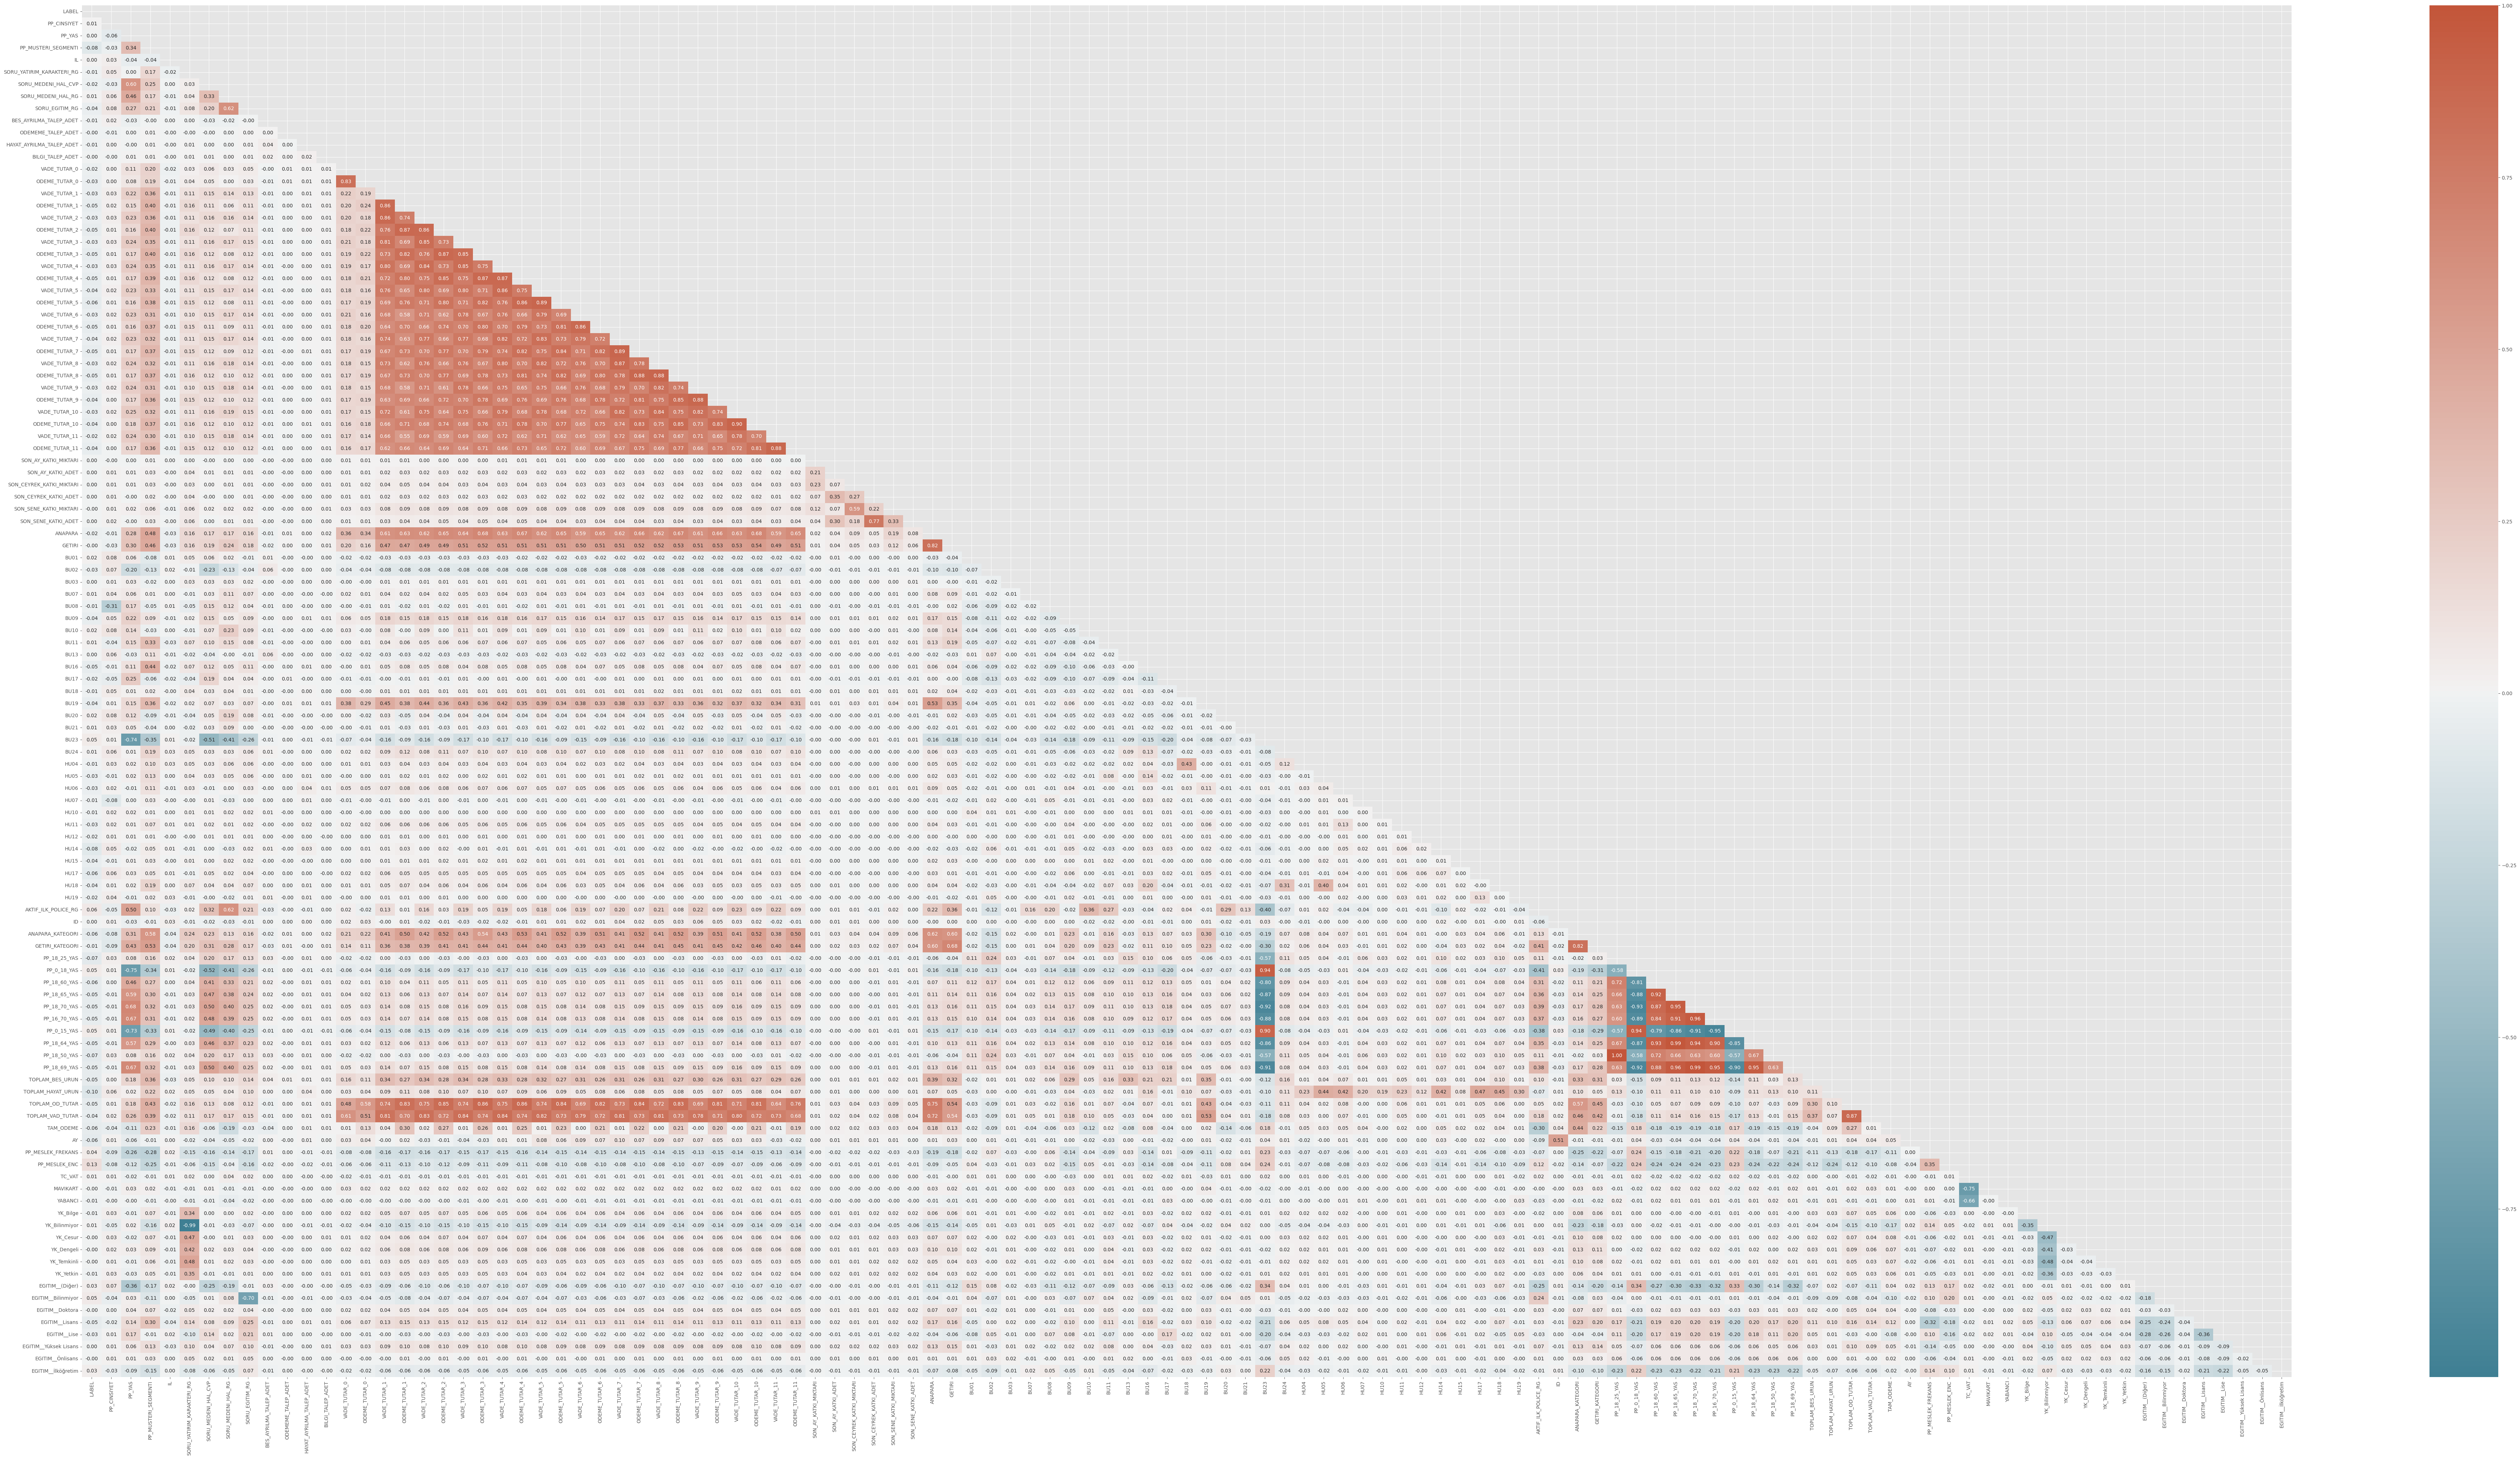

In [121]:
plt.figure(figsize=(100, 50))
num_variables = train_test_concat.select_dtypes(exclude="object")
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Korelasyon grafiğine bakınca toplam vade tutar ve toplam ödeme tutar. Bu değişkenlerin aylık bazda sağladığı bilgiyi temsil ediyor gibi görünmektedir. Bu nedenle bu değişkenler çıkarılmıştır.**

In [122]:
odeme_tutar_columns = train_test_concat.loc[:,train_test_concat.columns.str.contains("ODEME_TUTAR")].columns
train_test_concat.drop(odeme_tutar_columns,axis=1,inplace=True)
vade_tutar_columns = train_test_concat.loc[:,train_test_concat.columns.str.contains("VADE_TUTAR")].columns
train_test_concat.drop(vade_tutar_columns,axis=1,inplace=True)
train_test_concat.head()

MUSTERI_ID  LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7    7.0   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd    7.0   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f    6.0   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5    7.0   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491    7.0   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      42                    1  34                        -99   
1            0      74                    4  20                        -99   
2            0      48                    2   6                         26   
3            0      54                    0  34                        -99   
4            0      40                    3  77                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    0                  68              68   
1                    1                  11              11   
2                    0                 235             235   
3                    1                 111             111   
4                    1                  91              91   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  \
0                         0                      0                       0   
1                         0                      0                       0   
2                         0                      0                       0   
3                         0                      0                       0   
4                         0                      0                       0   

   SON_SENE_KATKI_ADET  ANAPARA  GETIRI  BU01  BU02  BU03  BU07  BU08  BU09  \
0                    0     2654     132     1     0     0     0     0     0   
1                    0    62945   75370     0     0     0     0     0     1   
2                    0    22929   16055     0     0     0     0     0     1   
3                    0      178     497     0     0     0     0     0     0   
4                    0     1378    1151     0     0     0     0     0     0   

   BU10  BU11  BU13  BU16  BU17  BU18  BU19  BU20  BU21  BU23  BU24  HU04  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     1     0     0     0     0     0   
2     0     0     0     0     1     0     0     0     0     0     0     0   
3     0     0     0     0     1     0     0     0     0     0     0     0   
4     0     0     0     1     0     0     0     0     0     0     0     0   

   HU05  HU06  HU07  HU10  HU11  HU12  HU14  HU15  HU17  HU18  HU19  \
0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     1     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0   

   AKTIF_ILK_POLICE_RG  ID  ANAPARA_KATEGORI  GETIRI_KATEGORI  PP_18_25_YAS 

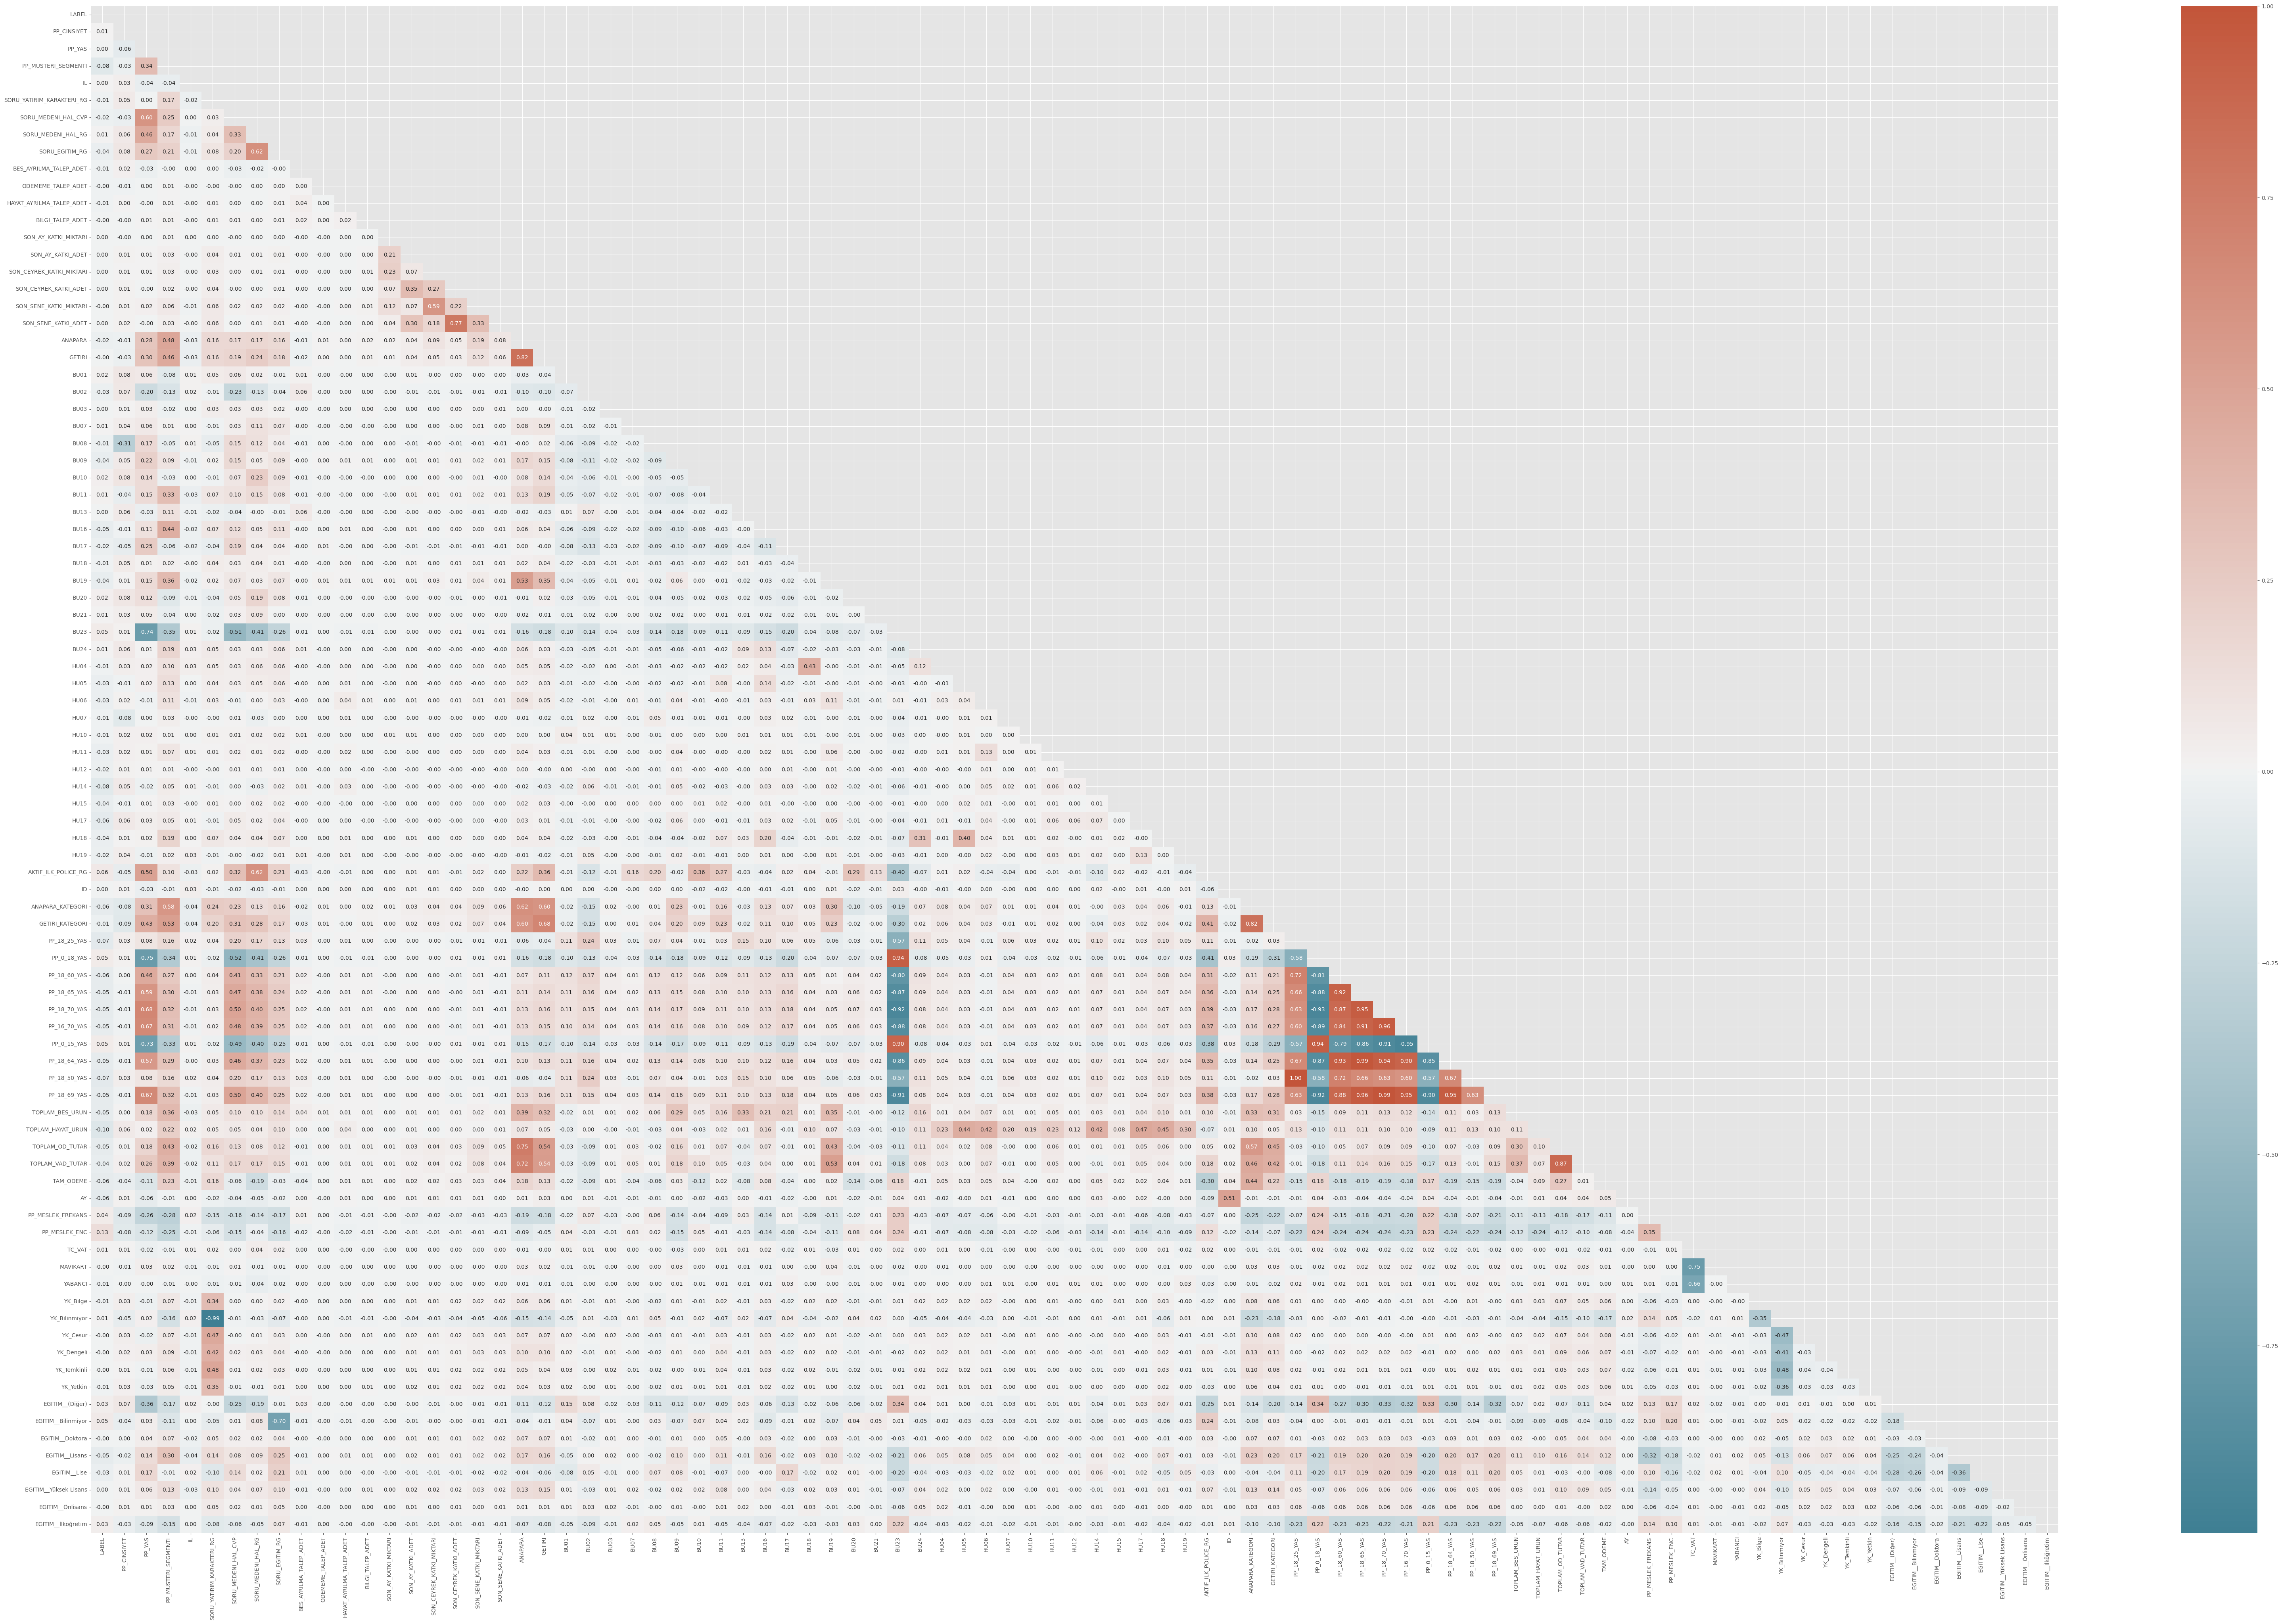

In [123]:
plt.figure(figsize=(80, 50))
num_variables = train_test_concat.select_dtypes(exclude="object")
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Multicollinearity probleminden dolayı 0.75 üzeri korelasyonlu olan değişkenlerin 1 tanesi overfittinge yol açmaması için veri setinden çıkarılmıştır. Bu değişkenler;**
- SON_SENE_KATKI_ADET ve SON_CEYREK_KATKI_ADET: 0.77 korelasyon var, SON_SENE_KATKI_ADET çıkarıldı.
- ANAPARA ve GETİRİ: 0.85 korelasyon var GETİRİ çıkarıldı.
- SORU_YATIRIM_KARAKTERİ_RG ve YK_Bilinmiyor: -0.99 negatif korelasyon var YK_bilinmiyor çıkarıldı.
- TOPLAM_OD_TUTAR ve TOPLAM_VAD_TUTAR: 0.87 TOPLAM_VAD_TUTAR çıkarıldı.
- ANAPARA_KATEGORI ve GETIRI KATEGORI: 0.82 GETIRI_KATEGORI çıkarıldı.
- TC_VAT ve MAVIKART: 0.75 negatif korelasyon MAVIKART çıkarıldı.


In [124]:
train_test_concat.drop(["SON_SENE_KATKI_ADET","GETIRI","YK_Bilinmiyor","TOPLAM_VAD_TUTAR","GETIRI_KATEGORI","MAVIKART"],axis=1,inplace=True)

- Target değişken LABEL ile diğer değişkenlerin 0.03 üzeri korelasyonları

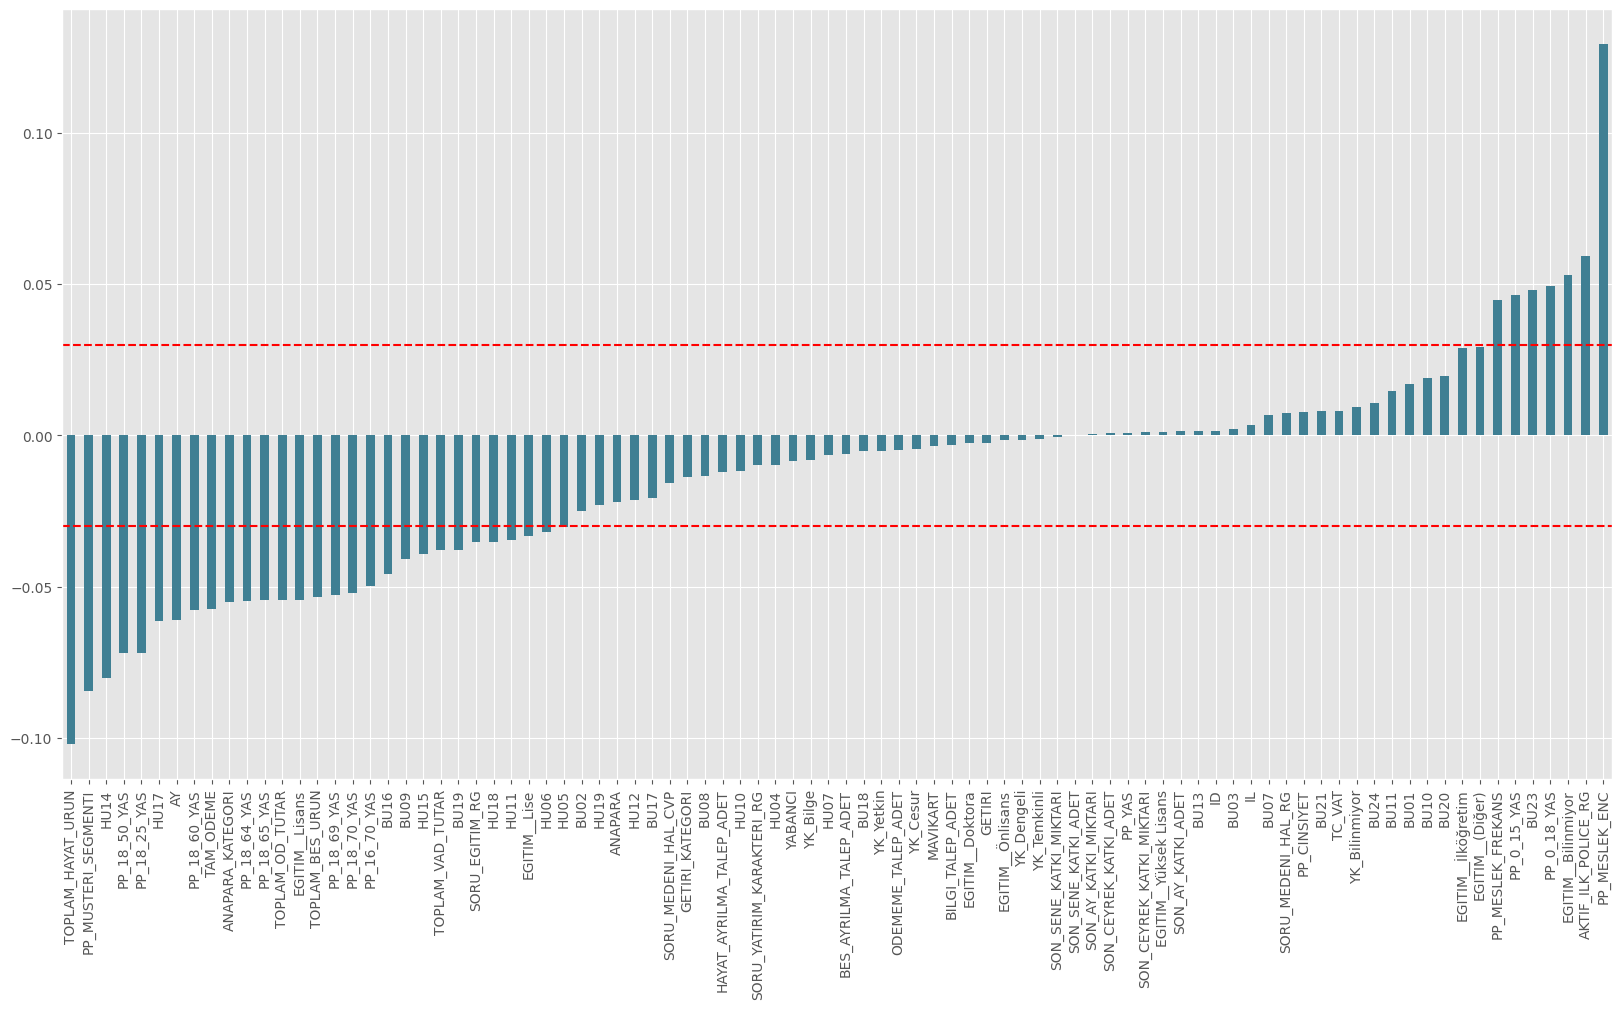

In [125]:
plt.figure(figsize=(20, 10))
tri_df["LABEL"].drop("LABEL").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [126]:
cor_target = abs(tri_df["LABEL"])
cor_target.drop("LABEL",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 83
Korelasyonlu özellik sayısı: 36


# MODEL OLUŞTURMA VE DEĞERLENDİRME

**Kullanılacak model fonksiyonu**
- İşleri kolay ve hatasız hale getirmek için tüm model eğitimi ve değerlendirme sürecini bir fonksiyonda modüler hale getirdim. Bu fonksiyon modeli, bölünmüş verileri, çapraz doğrulama fonksiyonunu, skor fonksiyonunu parametre olarak alır ve eğitilmiş modeli, eğitim ve doğrulama skorlarını içeren veri çerçevesini, nihai test skorunu ve test seti üzerindeki tahminleri döndürür. Plot parametresi de True olarak belirtilirse, eğitim ve doğrulama sonuçlarını çizer.  Eğitim verileri üzerinde çapraz doğrulama uygulamak model değerlendirme aşamasında sıklıkla tercih edilen bir yöntemdir. Bu sayede modelin eğitim, doğrulama ve test kümesi üzerindeki sonuçlarını karşılaştırarak aşırı uyum ve yetersiz uyum durumlarını daha kolay gözlemleyebilir ve hiperparametreleri bu sonuçlara göre ayarlayabiliriz. Ayrıca eğer problem sınıflandırma fonksiyonu ise karışıklık matrisini de yazdırır. Sklearn'deki karışıklık matrisi bize ilk satır olarak doğru negatif, yanlış pozitif tahminlerin sayılarını ve ikinci satır olarak da modelin yanlış negatif ve doğru pozitif tahminlerini gösterir.


In [127]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,score_func, cv_type, plot=True):
 
    """
    This function uses cross-validation method to evaluate the performance of a model and detect issues like overfitting or underfitting.

    Parameters:
    model : the model to be trained.
    X_train : pandas.DataFrame, splitted training dataset.
    y_train : pandas.Series, target variable of the training dataset.
    X_test : pandas.DataFrame, splitted test dataset.
    y_test : pandas.Series, target variable of the test dataset.
    score_func : function, evaluation metric. For example, accuracy_score, precision_score, recall_score, etc.
    cv_type : cross-validation strategy. For example, KFold, StratifiedKFold, etc.
    plot : bool, optional (default=True)
        Whether to plot the training and validation scores. If True, plots will be displayed.

    Returns:
    model : trained model.
    final_test_score : float, Metric score obtained on the test set.
    scores_df : pandas.DataFrame, Dataframe containing calculated train and validation scores.
    y_pred_test: pandas.Series, predictions on test set. if the score metric is roc_auc_score it returns predicted probabilities.
    """

    # defining the score lists
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # cross validation stage for detecting overfitting underfitting
    for train_index, test_index in cv_type.split(X_train,y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # model fit on cross validation training set
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # calculate train score
        train_score = score_func(y_train_cv, y_pred_train)
        # calculate validation score
        validation_score = score_func(y_validation_cv, y_pred_validation)

        # add scores to the train and validation lists
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # print the scores per fold
        print(f'Fold {fold} train_{score_func.__name__}: {train_score:.5f}')
        print(f'Fold {fold} validation_{score_func.__name__}: {validation_score:.5f}')

        fold += 1
        # fold list for plotting stage
        score_per_fold.append(fold)

    print("Cross validation stage has been completed! Model is started to training...")

    # After cross validation stage complated. Model trained on whole training set
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model training stage has been completed!")
    print("*******************************************")

    # predict on test set and it checks if the score function name is roc_auc_score we want to predicted probabilities that belongs to 1
    if score_func.__name__ == "roc_auc_score":
        y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = model.predict(X_test)
    
    # score on test set
    final_test_score = score_func(y_test, y_pred_test)

    # dictionary saves the scores
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"train_{score_func.__name__}": train_scores,
    f"validation_{score_func.__name__}": validation_scores
    }
    # dataframe for plotting
    scores_df = pd.DataFrame(scores_dict)

    # Validasyonun eğitime göre % farkı
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # Son testin eğitime göre % farkı
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

    print(f"Average train_{score_func.__name__} result: {np.mean(train_scores):.5f}")
    print(f'Average validation_{score_func.__name__} result: {np.mean(validation_scores):.5f}')
    print(f'Final test_{score_func.__name__} result: {final_test_score:.5f}')
    print(f'Validation percentage according to train:%{percentage_difference_train_valid:.2f}')
    print(f'Final test percentage according to train:%{percentage_difference_train_test:.2f}')
    
    # it prints confusion matrix if the problem is classification
    if score_func.__name__ in ["precision_score","recall_score","f1_score"]:
        cf_matrix = confusion_matrix(y_test, y_pred_test)
        print(f"Confusion Matrix on Final Test Set:\n {cf_matrix}")

    print("*******************************************")

    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"train_{score_func.__name__}", marker="o", label=f"train_{score_func.__name__}")
        sns.lineplot(data=scores_df, x="fold", y=f"validation_{score_func.__name__}", marker="v", label=f"validation_{score_func.__name__}")
        plt.xlabel("Fold")
        plt.ylabel(f"{score_func.__name__}")
        plt.title(f"{score_func.__name__} of each fold")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test

**Verilerin ayrılması**

In [128]:
new_train = train_test_concat[train_test_concat["ID"].isin(train["ID"])]
new_train["LABEL"] = new_train["LABEL"].astype(int)
new_test = train_test_concat[train_test_concat["ID"].isin(test["ID"])]


In [129]:
new_train.head()

MUSTERI_ID  LABEL  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7      7   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd      7   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f      6   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5      7   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491      7   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      42                    1  34                        -99   
1            0      74                    4  20                        -99   
2            0      48                    2   6                         26   
3            0      54                    0  34                        -99   
4            0      40                    3  77                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    0                  68              68   
1                    1                  11              11   
2                    0                 235             235   
3                    1                 111             111   
4                    1                  91              91   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  \
0                         0                      0                       0   
1                         0                      0                       0   
2                         0                      0                       0   
3                         0                      0                       0   
4                         0                      0                       0   

   ANAPARA  BU01  BU02  BU03  BU07  BU08  BU09  BU10  BU11  BU13  BU16  BU17  \
0     2654     1     0     0     0     0     0     0     0     0     0     0   
1    62945     0     0     0     0     0     1     0     0     0     0     0   
2    22929     0     0     0     0     0     1     0     0     0     0     1   
3      178     0     0     0     0     0     0     0     0     0     0     1   
4     1378     0     0     0     0     0     0     0     0     0     1     0   

   BU18  BU19  BU20  BU21  BU23  BU24  HU04  HU05  HU06  HU07  HU10  HU11  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     1     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   HU12  HU14  HU15  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG  ID  \
0     0     0     0     0     0     0                    9   0   
1     0     0     0     0     0     0                   11   1   
2     1     0     0     0     0     0                   66   2   
3     0     0     0     0     0     0                  111   3   
4     0     0     0     0     0     0                   90   4   

   ANAPARA_KATEGORI  PP_18_25_YAS  PP_0_18_YAS  PP_18_60_YAS  PP_18_65_YAS  \
0                 1   

In [130]:
new_train.shape

(852719, 84)

In [131]:
new_test.head()

MUSTERI_ID  LABEL  \
0  15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8    NaN   
1  7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0    NaN   
2  47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e    NaN   
3  48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87    NaN   
4  26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7    NaN   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      38                    3   1                        -99   
1            1      54                    0  54                        -99   
2            1      52                    0  48                        -99   
3            0      53                    0  67                        -99   
4            1       6                    0  34                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    1                 101             -99   
1                    1                 112             112   
2                    1                 219             219   
3                    1                 208             208   
4                    0                   4               4   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  \
0                         0                      0                       0   
1                         0                      0                       0   
2                         0                      0                       0   
3                         0                      0                       0   
4                         0                      0                       0   

   ANAPARA  BU01  BU02  BU03  BU07  BU08  BU09  BU10  BU11  BU13  BU16  BU17  \
0     6121     0     0     0     0     0     0     0     1     0     0     0   
1    42088     0     0     1     0     0     0     0     0     0     0     0   
2       98     0     0     0     0     0     3     0     0     0     0     0   
3      368     0     0     0     0     1     0     0     0     0     0     0   
4     1184     0     0     0     0     0     0     0     0     0     0     0   

   BU18  BU19  BU20  BU21  BU23  BU24  HU04  HU05  HU06  HU07  HU10  HU11  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     1     0     0     0     0     0     0     0   

   HU12  HU14  HU15  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG      ID  \
0     0     0     0     0     0     0                  100  852719   
1     0     0     0     0     0     0                  111  852720   
2     0     0     0     0     0     0                  127  852721   
3     0     0     0     0     0     0                  178  852722   
4     0     0     0     0     0     0                    3  852723   

   ANAPARA_KATEGORI  PP_18_25_YAS  PP_0_18_YAS  PP_18_60_YAS  PP_18_65_YAS  

In [132]:
new_test.shape

(195631, 84)

**Eğitim verisinin train test split ile ayrılması**

In [133]:
target = "LABEL"
columns_that_will_not_used = ["MUSTERI_ID","ID","LABEL","SON_AY_KATKI_ADET","PP_18_25_YAS","PP_0_18_YAS","PP_18_60_YAS","PP_18_65_YAS","PP_18_70_YAS","PP_16_70_YAS","PP_0_15_YAS","PP_18_64_YAS","PP_18_50_YAS","PP_18_69_YAS","TAM_ODEME"]
feature_columns = [col for col in new_train.columns if col not in columns_that_will_not_used]
X = new_train[feature_columns]
y= new_train[target]


**SMOTE ile oversampling uygulandı**

In [134]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, stratify=y_smote, random_state=42)

In [136]:
len(X_train.columns)

69

In [137]:
new_train["LABEL"].value_counts(normalize=True)

LABEL
7    0.976605
4    0.012611
1    0.004372
0    0.003727
6    0.000890
3    0.000793
2    0.000515
5    0.000487
Name: proportion, dtype: float64

In [138]:
y_train.value_counts(normalize=True)

LABEL
2    0.125
5    0.125
7    0.125
0    0.125
3    0.125
4    0.125
1    0.125
6    0.125
Name: proportion, dtype: float64

In [139]:
y_test.value_counts(normalize=True)

LABEL
5    0.125
2    0.125
7    0.125
1    0.125
4    0.125
6    0.125
3    0.125
0    0.125
Name: proportion, dtype: float64

In [140]:
def weighted_f1_score(y_true, y_pred):
    #classes = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19', 'UA']
    labels = [0, 1, 2, 3, 4, 5, 6, 7]
    weights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])
    return np.sum(f1_score(y_true, y_pred, average=None, labels=labels) * weights)

**LOGISTICREGRESSION MODELI**

**Logistic regression GridSearch hiperparametre ayarı**

In [141]:
# skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# scoring = make_scorer(weighted_f1_score) 
# lr_cv = LogisticRegression()

# lr_pipeline_cv = Pipeline([
#     ("scaler", MaxAbsScaler()),
#     ("classifier", lr_cv)
# ])

# params_lr = {
#     #"classifier__penalty": ["l1", "l2","elasticnet"],
#     "classifier__C": [0.0001, 0.001, 0.01, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 200],
#     "classifier__class_weight": ["balanced"],
#     "classifier__multi_class": ["multinomial"],
# } 

# grid_rf = GridSearchCV(estimator=lr_pipeline_cv,param_grid=params_lr,cv=skf,scoring=scoring,verbose=1,n_jobs=-1)

# grid_rf.fit(X,y)
# best_hyperparams_lr = grid_rf.best_params_
# best_score_lr = grid_rf.best_score_
# print("Best hyperparameters for Logistic Regression:", best_hyperparams_lr)
# print("Best score for Logistic Regression:", best_score_lr)

In [142]:
# Best hyperparameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__multi_class': 'multinomial'}
# Best score for Logistic Regression: 0.0710406488080925

Fold 1 train_weighted_f1_score: 0.58063
Fold 1 validation_weighted_f1_score: 0.58132
Fold 2 train_weighted_f1_score: 0.58211
Fold 2 validation_weighted_f1_score: 0.58219
Fold 3 train_weighted_f1_score: 0.58306
Fold 3 validation_weighted_f1_score: 0.58298
Fold 4 train_weighted_f1_score: 0.58422
Fold 4 validation_weighted_f1_score: 0.58455
Fold 5 train_weighted_f1_score: 0.58117
Fold 5 validation_weighted_f1_score: 0.58033
Cross validation stage has been completed! Model is started to training...
*******************************************
Model training stage has been completed!
*******************************************
Average train_weighted_f1_score result: 0.58224
Average validation_weighted_f1_score result: 0.58227
Final test_weighted_f1_score result: 0.58199
Validation percentage according to train:%0.01
Final test percentage according to train:%-0.04
*******************************************


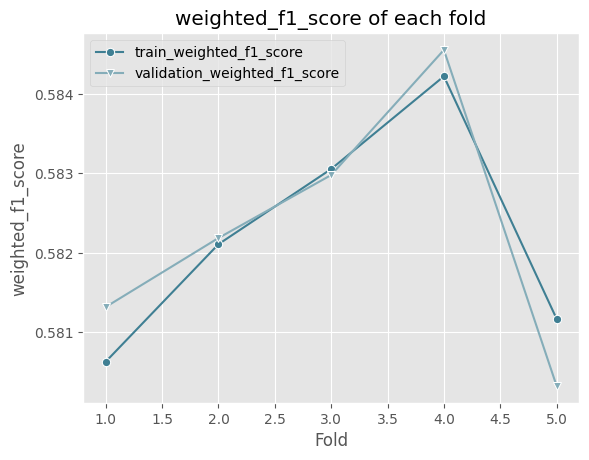

In [143]:
lr = LogisticRegression(C=1, class_weight="balanced",multi_class="multinomial")

lr_pipeline = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("classifier", lr)
])
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
lr_model, lr_final_test_weighted_f1_score, lr_weighted_f1_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test,weighted_f1_score, skf, plot=True)

In [147]:
f1_scores = f1_score(y_test, lr_y_pred_test, average=None).tolist()
classes = ["HU06", "HU07", "HU11", "HU12", "HU14", "HU15", "HU19", "UA"]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
weights =[0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001]
score_dict = {"classes":classes, "labels":labels, "weights":weights, "f1_scores":f1_scores}
score_df = pd.DataFrame(score_dict)
score_df["weights * f1_scores"] = score_df["weights"] * score_df["f1_scores"]
score_df

classes  labels  weights  f1_scores  weights * f1_scores
0    HU06       0   0.0385   0.360175             0.013867
1    HU07       1   0.0328   0.557771             0.018295
2    HU11       2   0.2791   0.575103             0.160511
3    HU12       3   0.1812   0.549684             0.099603
4    HU14       4   0.0113   0.299843             0.003388
5    HU15       5   0.2952   0.725683             0.214222
6    HU19       6   0.1614   0.446251             0.072025
7      UA       7   0.0001   0.751229             0.000075

In [148]:
score_df["weights * f1_scores"].sum()

0.5819854677774001

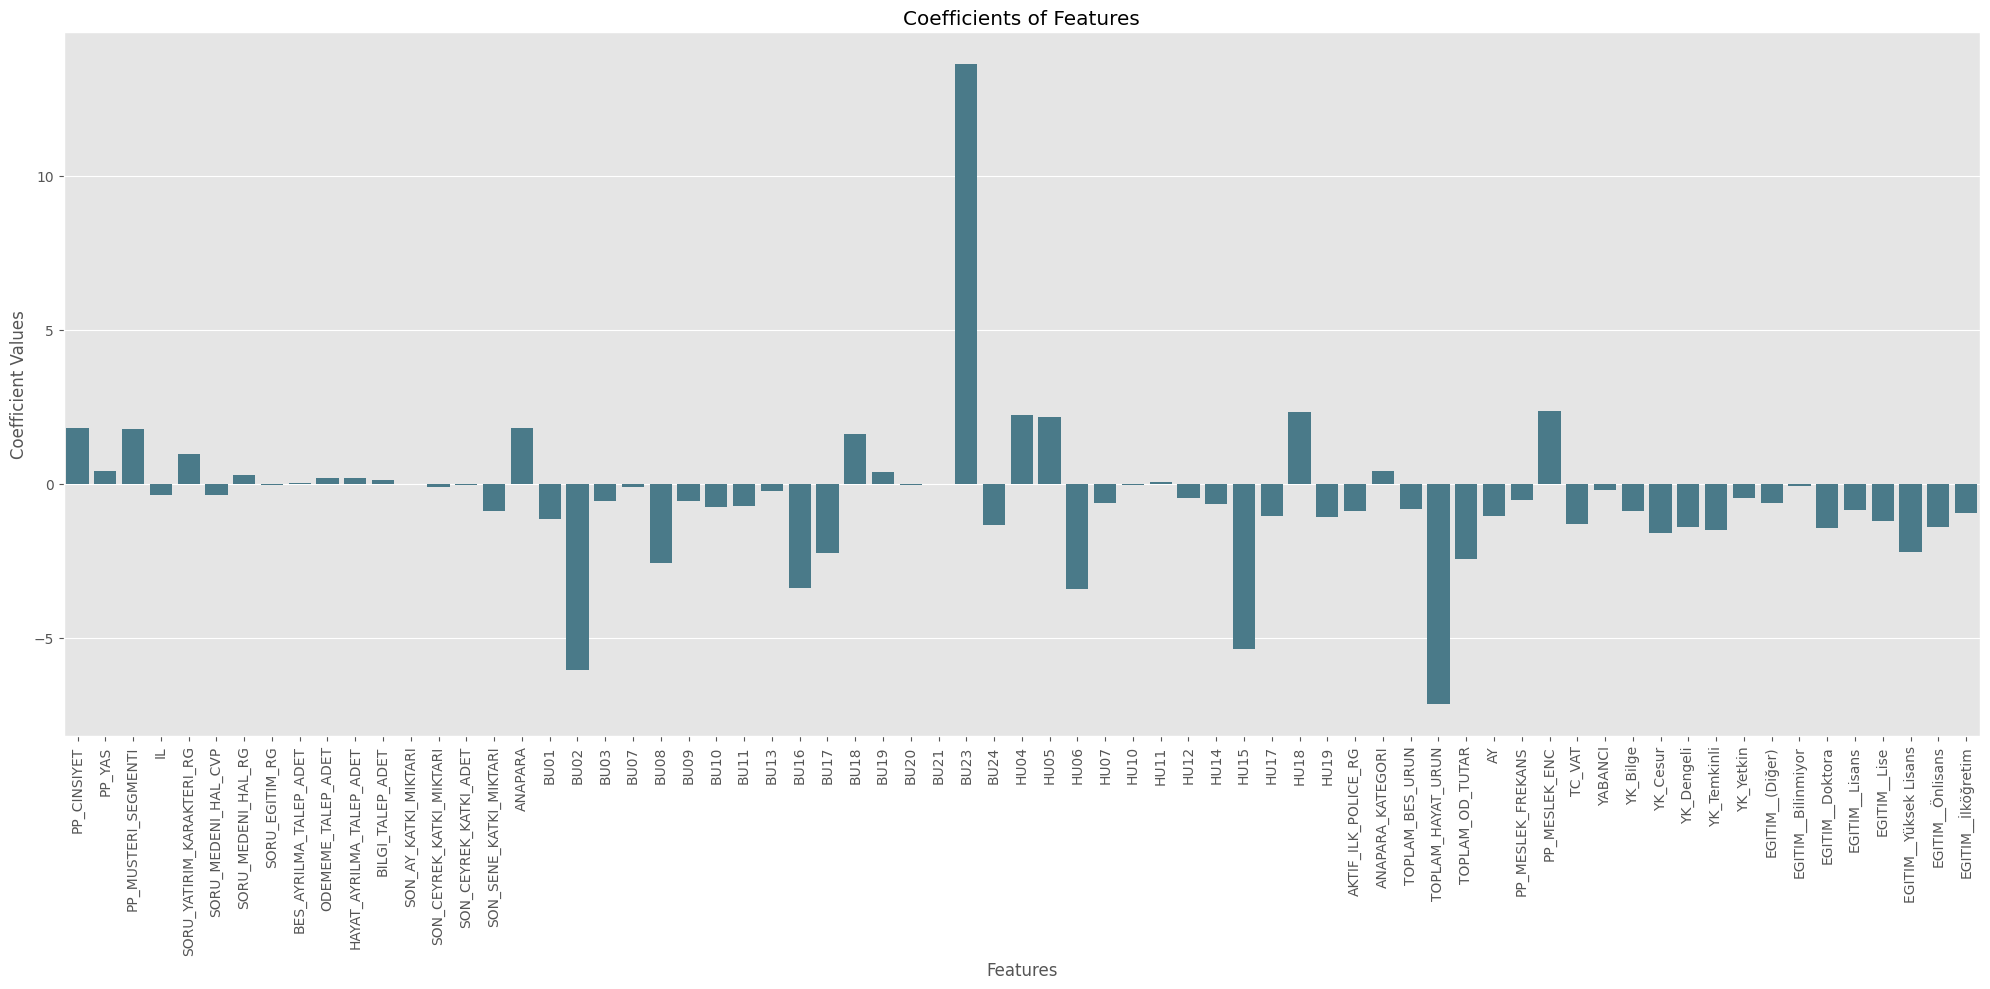

In [149]:
coef_values = lr_model.named_steps["classifier"].coef_[0]
columns = X_train.columns

plt.figure(figsize=(20, 10))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Coefficients of Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**XGBOOST CLASSIFIER MODELI**

In [ ]:
# xgb_clf = XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
#                                 objective="multi:softmax", booster='gbtree', 
#                                 n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
#                                 subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
#                                 scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=True)
# xgb_clf.get_params()

In [150]:
xgb_clf = XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=500, 
                                objective="multi:softmax", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1,
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)
xgb_clf.get_params()

{'objective': 'multi:softmax',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 1,
 'nthread': None}

Fold 1 train_weighted_f1_score: 0.83562
Fold 1 validation_weighted_f1_score: 0.83588
Fold 2 train_weighted_f1_score: 0.83636
Fold 2 validation_weighted_f1_score: 0.83518
Fold 3 train_weighted_f1_score: 0.83640
Fold 3 validation_weighted_f1_score: 0.83553
Fold 4 train_weighted_f1_score: 0.83676
Fold 4 validation_weighted_f1_score: 0.83586
Fold 5 train_weighted_f1_score: 0.83657
Fold 5 validation_weighted_f1_score: 0.83558
Cross validation stage has been completed! Model is started to training...
*******************************************
Model training stage has been completed!
*******************************************
Average train_weighted_f1_score result: 0.83634
Average validation_weighted_f1_score result: 0.83561
Final test_weighted_f1_score result: 0.83316
Validation percentage according to train:%-0.09
Final test percentage according to train:%-0.38
*******************************************


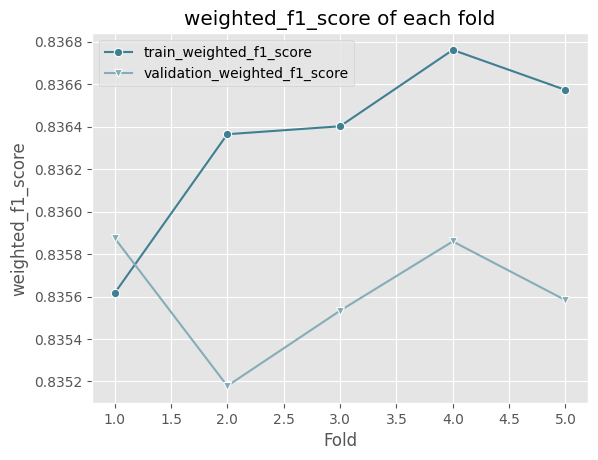

In [151]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

xgb_clf_model, xgb_clf_final_test_weighted_f1_score, xgb_clf_weighted_f1_score_df, xgb_clf_y_pred_test = train_and_evaluate_model(xgb_clf, X_train, y_train, X_test, y_test,weighted_f1_score, skf, plot=True)

In [152]:
f1_scores = f1_score(y_test, xgb_clf_y_pred_test, average=None).tolist()
classes = ["HU06", "HU07", "HU11", "HU12", "HU14", "HU15", "HU19", "UA"]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
weights =[0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001]
score_dict_xgb = {"classes":classes, "labels":labels, "weights":weights, "f1_scores":f1_scores}
score_df_xgb = pd.DataFrame(score_dict_xgb)
score_df_xgb["weights * f1_scores"] = score_df_xgb["weights"] * score_df_xgb["f1_scores"]
score_df_xgb

classes  labels  weights  f1_scores  weights * f1_scores
0    HU06       0   0.0385   0.698993             0.026911
1    HU07       1   0.0328   0.728206             0.023885
2    HU11       2   0.2791   0.858578             0.239629
3    HU12       3   0.1812   0.808222             0.146450
4    HU14       4   0.0113   0.534278             0.006037
5    HU15       5   0.2952   0.903657             0.266760
6    HU19       6   0.1614   0.764539             0.123397
7      UA       7   0.0001   0.923019             0.000092

In [153]:
score_df_xgb["weights * f1_scores"].sum()

0.8331611668264336

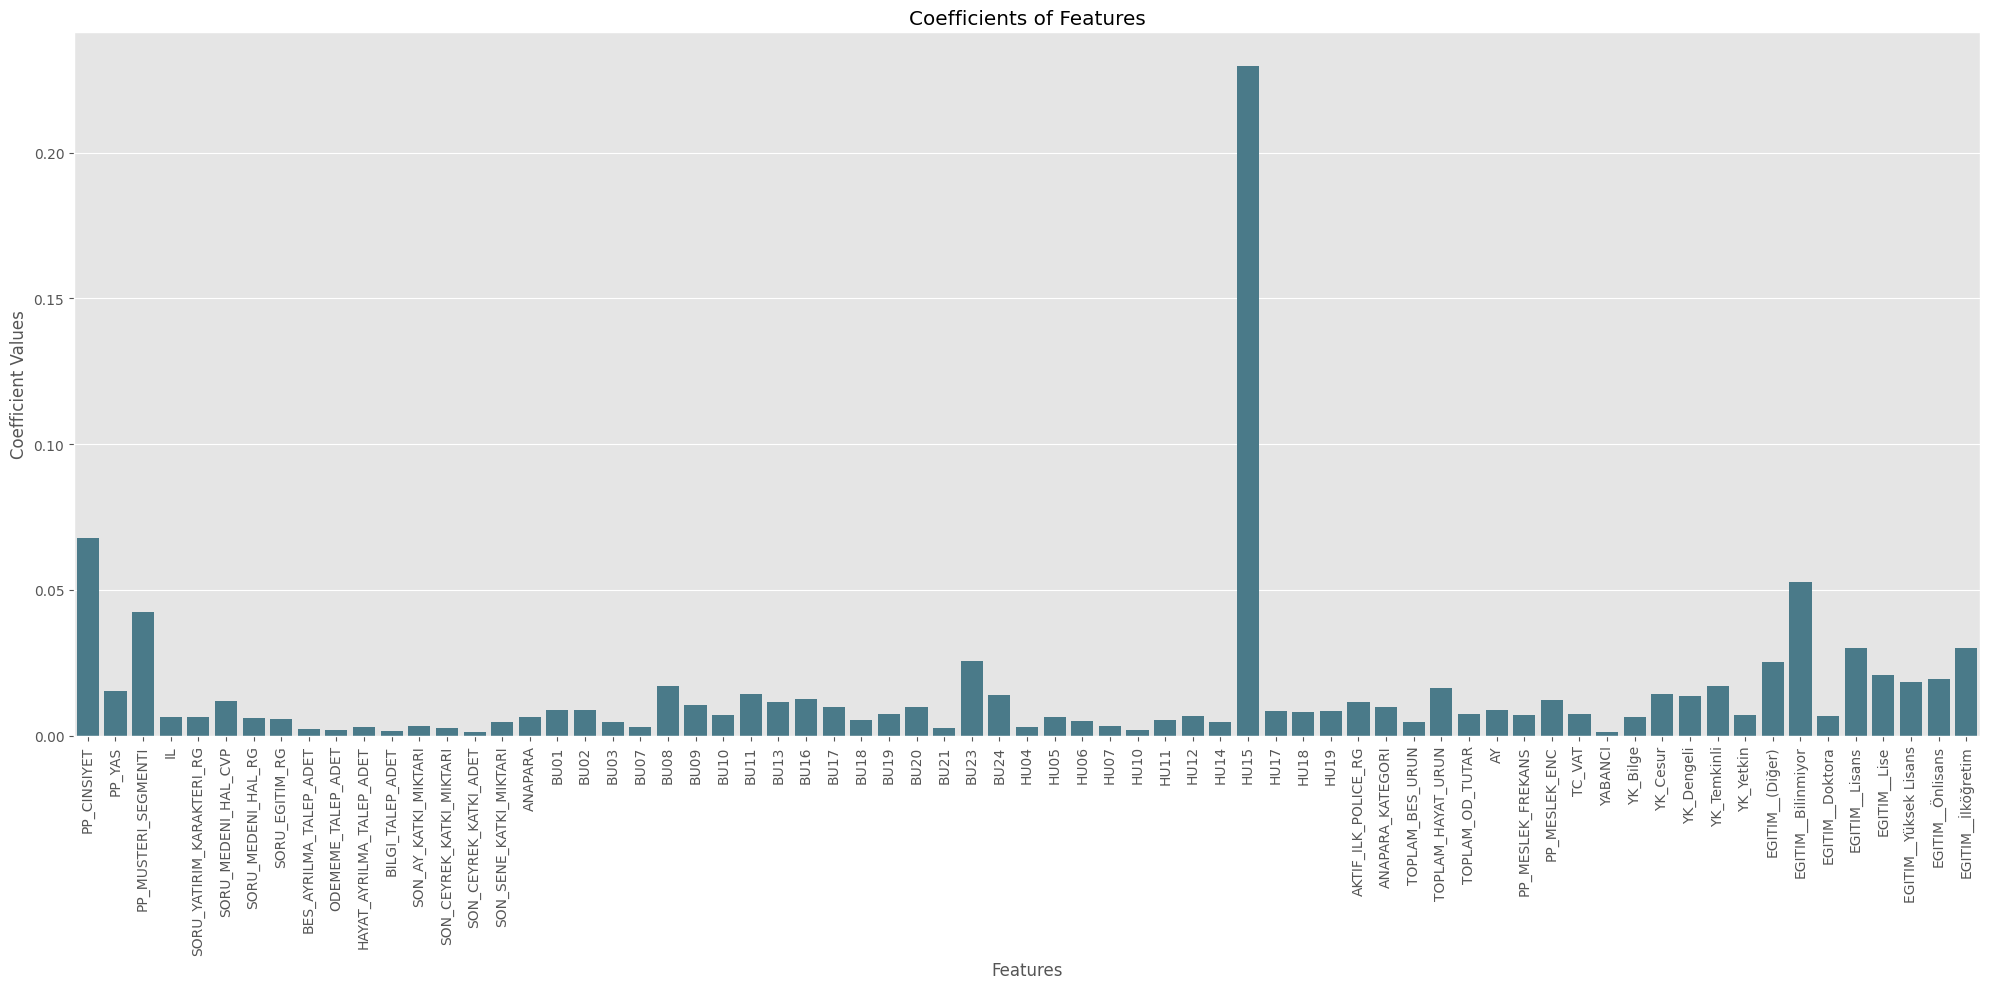

In [154]:
feature_importances = xgb_clf_model.feature_importances_
columns = X_train.columns
plt.figure(figsize=(20, 10))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Coefficients of Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**MODEL KARŞILAŞTIRMA**

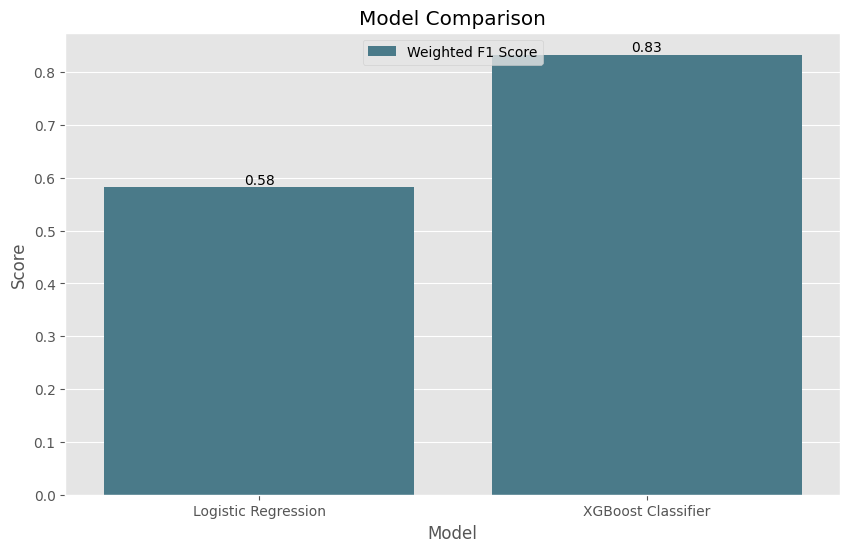

In [155]:
scores_data = {
    "Model": ["Logistic Regression", "XGBoost Classifier"],
    "Metric": ["Weighted F1 Score", "Weighted F1 Score"],
    "Score": [lr_final_test_weighted_f1_score, xgb_clf_final_test_weighted_f1_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Score", hue="Metric", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**SON TAHMIN VE SUBMISSION OLUŞTURULMASI**

- Tahmin

In [156]:
final_test = new_test[X_train.columns]
new_test.loc[:, "LABEL"] = xgb_clf_model.predict(final_test)
new_test["LABEL"] = new_test["LABEL"].astype(int)
#Labellerin ilgili etiketlere atanması
classes = ["HU06", "HU07", "HU11", "HU12", "HU14", "HU15", "HU19", "UA"]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
label_dict = dict(zip(labels, classes))
new_test["LABEL"] = new_test["LABEL"].map(label_dict)
new_test.head()

MUSTERI_ID LABEL  \
0  15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8    UA   
1  7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0    UA   
2  47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e    UA   
3  48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87    UA   
4  26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7    UA   

   PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  IL  SORU_YATIRIM_KARAKTERI_RG  \
0            0      38                    3   1                        -99   
1            1      54                    0  54                        -99   
2            1      52                    0  48                        -99   
3            0      53                    0  67                        -99   
4            1       6                    0  34                        -99   

   SORU_MEDENI_HAL_CVP  SORU_MEDENI_HAL_RG  SORU_EGITIM_RG  \
0                    1                 101             -99   
1                    1                 112             112   
2                    1                 219             219   
3                    1                 208             208   
4                    0                   4               4   

   BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  \
0                       0                   0                         0   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   BILGI_TALEP_ADET  SON_AY_KATKI_MIKTARI  SON_AY_KATKI_ADET  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   SON_CEYREK_KATKI_MIKTARI  SON_CEYREK_KATKI_ADET  SON_SENE_KATKI_MIKTARI  \
0                         0                      0                       0   
1                         0                      0                       0   
2                         0                      0                       0   
3                         0                      0                       0   
4                         0                      0                       0   

   ANAPARA  BU01  BU02  BU03  BU07  BU08  BU09  BU10  BU11  BU13  BU16  BU17  \
0     6121     0     0     0     0     0     0     0     1     0     0     0   
1    42088     0     0     1     0     0     0     0     0     0     0     0   
2       98     0     0     0     0     0     3     0     0     0     0     0   
3      368     0     0     0     0     1     0     0     0     0     0     0   
4     1184     0     0     0     0     0     0     0     0     0     0     0   

   BU18  BU19  BU20  BU21  BU23  BU24  HU04  HU05  HU06  HU07  HU10  HU11  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     1     0     0     0     0     0     0     0   

   HU12  HU14  HU15  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG      ID  \
0     0     0     0     0     0     0                  100  852719   
1     0     0     0     0     0     0                  111  852720   
2     0     0     0     0     0     0                  127  852721   
3     0     0     0     0     0     0                  178  852722   
4     0     0     0     0     0     0                    3  852723   

   ANAPARA_KATEGORI  PP_18_25_YAS  PP_0_18_YAS  PP_18_60_YAS  PP_18_65_YAS  \
0   

In [159]:
new_test["LABEL"].value_counts(normalize=True)

LABEL
UA      0.928089
HU07    0.023156
HU14    0.017323
HU19    0.010775
HU06    0.008271
HU12    0.007018
HU11    0.004739
HU15    0.000629
Name: proportion, dtype: float64

In [160]:
train_test_concat["LABEL"].value_counts(normalize=True)

LABEL
7.0    0.976605
4.0    0.012611
1.0    0.004372
0.0    0.003727
6.0    0.000890
3.0    0.000793
2.0    0.000515
5.0    0.000487
Name: proportion, dtype: float64

- Submission

In [161]:
new_test[["MUSTERI_ID","LABEL"]].to_csv('submissions/submission11.csv',index=False)